# Network Tour of Data Science - Project
## American Basketball Players
#### Olivier Couque, Emma Lejal Glaude & Matthieu Sauvé

We would like to explore the network of American Basketball Players. The NBA players are well known for their presence on Twitter which provides us a way to analyze the existing connections between players. We are going to gather the information from Twitter thanks to Tweepy, and Wikipedia thanks to BeatifulSoup. Once we have a graph with the connections, we will be able to run clustering algorithms and discover if we can recognize the teams, the divisions or the conferences. There are 30 different teams, grouped in 6 different divisions (partitioned in roughly North-Center-South) again grouped in 2 different divisions (partitioned by East-West).<br> At first glance, as we already know the number of clusters, k-means could be a good start, although we will test other methods such as Spectral Clustering, Gaussian Mixture Model and PCA dimensionality reduction paired with K-Means.


<a id='index'></a>

Table of content :
1. [Data collection & data cleaning](#clean)
2. [Clustering Methods](#methods)
3. [Player-Player Graph](#ppgraph)
    1. [Construction](#ppconstruct)
    2. [Analysis](#ppanalysis)
    3. [Cluster per Conference](#ppconf)
    4. [Cluster per Division](#ppdiv)
    5. [Cluster per Team](#ppteam)
    6. [Optimal graph analysis](#optimal)
4. [Player-Team Graph](#ptgraph)
    1. [Construction](#ptconstruct)
    2. [Analysis](#ptanalysis)
    3. [Cluster per Team](#ptteam)
5. ["Rookie" Graph](#rookie)
    1. [Construction](#rookieconstruct)
    2. [Analysis](#rookieanalysis)
    3. [Cluster per Team](#rookieteam)
6. [Double Connection Graph](#double)
    1. [Construction](#doubleconstruct)
    2. [Analysis](#doubleanalysis)
    3. [Cluster per Team](#doubleteam)
7. [Conclusion](#ccl)

In [2]:
#Usefull imports
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

<a id='clean'></a>

# 1. Data collection & data cleaning

First we import the data concerning the teams. By that we mean the list of teams, in which division and which conference they belong, alongside with their Twitter account. <br>
To gather the information we used this website : http://hoopeduponline.com/2009/03/30/a-list-of-every-nba-player-on-twitter/ <br>
After gathering the teams with their division and conference, we created a csv file.

In [3]:
#Load the data file into a Dataframe
teams = pd.DataFrame.from_csv('teams.csv').reset_index()
teams = teams.set_index(['Conference', 'Division'])
teams.head()

Team        Twitter
Conference         Division                                            
EASTERN CONFERENCE Atlantic Division      Boston Celtics       @celtics
                   Atlantic Division       Brooklyn Nets  @BrooklynNets
                   Atlantic Division     New York Knicks      @nyknicks
                   Atlantic Division  Philadelphia 76ers        @Sixers
                   Atlantic Division     Toronto Raptors       @raptors

This website also provided us with the data from the teams repartition of players of 2013. <br>
We can get here some twitter names of players, though the team repartition has evolved a lot as the NBA sees a lot of trades of players between teams (some players can change team up to twice a year). This data is useful for the twitter name of the players. Many might still play in 2017. However we cannot use the team repartition.

In [4]:
players_2013 = pd.DataFrame.from_csv('players_twitter_2013.csv')
players_2013 = players_2013.drop_duplicates(subset='Twitter_name')
players_2013.head()

Twitter_name            Team
Name                                           
Kelly Olynyk       @KellyOlynyk  Boston Celtics
Brandon Bass       @bestbetbass  Boston Celtics
Avery Bradley      @aabradley11  Boston Celtics
Kris Humphries   @KrisHumphries  Boston Celtics
Jeff Green      @unclejeffgreen  Boston Celtics

In order to get the correct repartition of players among the teams, we will base ourselves on this wikipedia page : https://en.wikipedia.org/wiki/List_of_current_NBA_team_rosters . <br>
We will use Request and BeautifulSoup to parse the HTML and retreive the data that are of our use by retreiving the related HMTL tags.

In [5]:
#Function to get the parsed HTML of a given URL
def get_soup(url):
    r = requests.get(url)
    return BeautifulSoup(r.text, 'html.parser')

In [6]:
#Parsed HTML of Wikipedia Teams page
soup_teams = get_soup('https://en.wikipedia.org/wiki/List_of_current_NBA_team_rosters')

In [7]:
#Get all the team names
#We find in the structure that the names are in header 4 tags
teams_h4 = soup_teams.findAll('h4')
#Extract team name as a string
team_names = [t.find('a').get('title') for t in teams_h4]
team_names[:5]

['Boston Celtics',
 'Brooklyn Nets',
 'New York Knicks',
 'Philadelphia 76ers',
 'Toronto Raptors']

Now that we have the teams, we will get the references in the team HTML-divisions. Some describe the role of the player, some say the university or country of origin of the player. We need to clean them and keep only the players names and wikipedia personal page url. <br>
Indeed some of the famous have a link to their twitter account in the External Link part at the end of their personal wikipedia page. We will use this as a second source of information for the twitter accounts.

In [8]:
#Key words to find the text corresponding to a role on the team
roles_keywords = ['basketball', 'Swingman', 'Forward-center' ]

In [9]:
#Get rid of refs which represent a role as a player
def clean_roles(wikis):
    wo_basketball_wikis = []
    for w in wikis :
        #Add to the list only if none of the keywords are contained
        if any([x in w for x in roles_keywords]):
            continue
        else: 
            wo_basketball_wikis.append(w)
    return wo_basketball_wikis

In [10]:
#Key words to find the text corresponding to a university
uni_keywords = ['University','Institute', 'Sciences', 'School', 'College', 'Academy', 'Tech']

In [11]:
#Get rid of refs which represent a university
def clean_universities(wikis):
    wo_univ_wikis = []
    for w in wikis :
        #Add to the list if none of the keywords are contained
        if any([x in w for x in uni_keywords]):
            continue
        else: 
            wo_univ_wikis.append(w)
    return wo_univ_wikis

In [12]:
#Key words to find the last countries to clean
countries_to_clean = ['/wiki/North_Carolina', '/wiki/Bosnia_and_Herzegovina','/wiki/DR_Congo',
                 '/wiki/Czech_Republic','/wiki/Georgia_(country)']

In [13]:
#Get rid of countries (mainly they don't have '-', or see countries_to_cleann)
def clean_countries(wikis):
    player_wikis = []
    for w in wikis :
        try:
            #Players string contain a '_' representing the space between first and last name
            #Though if a string does not contain it, it must be a country
            w.index('_')
            #Also check the special cases of countries
            if any([x in w for x in countries_to_clean]):
                continue
            else:
                player_wikis.append(w)
        except ValueError : 
            continue
    return player_wikis

In [14]:
#With the list of references, do all operations of cleaning to keep only the players names.
def clean_refs(wikis):
    res = clean_roles(wikis)
    res = clean_universities(res)
    return clean_countries(res)

In [15]:
#Add to the dataframe the player with team and twitter from the wikipedia page of player
def add_players_with_twitter(df, team_name, player_wikis):
    #player_wikis is the list of all player wikipedia pages of this team
    for p in player_wikis:
        #Retreive the soup of the personal wikipedia page of the player
        soup_player = get_soup('https://en.wikipedia.org' + p)
        #Retreive the external links at the end (might contain Twitter link)
        inner_div = soup_player.find('div', attrs = {'class' :'mw-parser-output'})
        last_h2 = inner_div.findAll('h2')[-1]
        ext_refs = last_h2.findAllNext('a', attrs = {'class' : 'external text', 'rel': 'nofollow'})

        twitter = ''
        for r in ext_refs:
            u = r.get('href')
            #Check if any of the refs is the twitter link, if yes include in dataframe
            if 'twitter' in u:
                twitter = u
        #Add player to the dataframe
        df.loc[len(df)] = [team_name, p, twitter ]

In [16]:
#Create the empty dataframe for team, player and twitter
df = pd.DataFrame(columns = ['team', 'wiki_player', 'twitter'])
#Get the tables of each teams from the soup of the wikipedia team page
tables = soup_teams.findAll('table')
#Keep track of which team we are working on
nb_team = 0
#All tables are dupplicates so, take only one over two
for i in np.arange(1, 60, 2):
    #Retreive all the references
    refs = tables[i].findAll('a')
    wikis = []
    for r in refs:
        wikis.append(r.get('href'))
    #Apply cleaning to get only the player names
    clean_wikis = clean_refs(wikis)
    #Indication of progess and number of player per team
    print(team_names[nb_team], ': ', len(clean_wikis))
    #Add the player to the dataframe with potential twitter info
    add_players_with_twitter(df, team_names[nb_team], clean_wikis)
    #Go to next team
    nb_team += 1

Boston Celtics :  16
Brooklyn Nets :  16
New York Knicks :  16
Philadelphia 76ers :  14
Toronto Raptors :  15
Chicago Bulls :  16
Cleveland Cavaliers :  13
Detroit Pistons :  14
Indiana Pacers :  13
Milwaukee Bucks :  14
Atlanta Hawks :  15
Charlotte Hornets :  16
Miami Heat :  15
Orlando Magic :  16
Washington Wizards :  12
Dallas Mavericks :  17
Houston Rockets :  14
Memphis Grizzlies :  15
New Orleans Pelicans :  11
San Antonio Spurs :  14
Denver Nuggets :  17
Minnesota Timberwolves :  12
Oklahoma City Thunder :  14
Portland Trail Blazers :  15
Utah Jazz :  14
Golden State Warriors :  13
Los Angeles Clippers :  15
Los Angeles Lakers :  14
Phoenix Suns :  14
Sacramento Kings :  13


In order to extract the name of the players from their wikipedia link, we must clean the special characters. As there are not so many of them, we can do the mapping manually.

In [17]:
special_char_map = {
    '%27' : '\'',
    '%C3%B3' : 'o',
    '%C5%86' : 'n',
    '%C4%A3' : 'g',
    '%C3%A9' : 'é',
    '%C5%A0' : 'S',
    '%C4%87' : 'c' ,
    '%C3%B6' : 'ö' ,
    '%C4%8D' : 'c' ,
    '%C5%AB' : 'u' ,
    '%C3%AD' : 'i' ,
    '%C5%BD' : 'Z' ,
    '%C5%BE' : 'z' ,
    '%C4%B0' : 'I' ,
    '%C3%A1' : 'a' ,
    '%C5%A1' : 's' ,
    '%C3%BD' : 'y' ,
    '%C3%A7' : 'c' ,
    '%C3%96' : 'O' ,
    '%C5%9F' : 's' ,
    '%C4%B1' : 'i' ,
    '%C4%81' : 'a' ,
    '%C3%81' : 'A' ,
    '%C3%A8' : 'è' 
}

In [18]:
#Function that returns the name of the player from the wiki link
def get_name_from_wiki(wiki):
    #First get rid of the wiki part
    name = wiki.replace('/wiki/', '')
    #Now we can replace the _ for the space that they represent
    name = name.replace('_', ' ')
    #This special character has a different form, so we treat it separately
    name = name.replace('%27', '\'')
    #For all other special character, here is what we do
    while '%' in name:
        #We extract the special char which starts by '%' and has 5 char after
        spec_char = name[name.index('%'):(name.index('%')+ 6)]
        #We replace this special char by the corresponding value in our mapping
        name = name.replace(spec_char, special_char_map[spec_char])
    return name

In [19]:
#We apply the cleaning on the wiki column to get the new Name column
df['Name'] = df['wiki_player'].map(lambda w : get_name_from_wiki(w))

Now that we have a clean column name we can merge the dataframes in hope to fill more Twitter name information.

In [20]:
players_2017 = df.join(players_2013.reset_index().set_index('Name'), how ='outer', on ='Name')

In [23]:
#Drop the dupplicate information of team (outdated in 2013 data anyway)
players_2017 = players_2017.drop('Team', axis=1)

In [24]:
#Drop the Nan of team as they represent the players that don't play in 2017 anymore.
players_2017 = players_2017.dropna(subset=['team']) 

In [25]:
players_2017.head()

team         wiki_player twitter          Name Twitter_name
0  Boston Celtics  /wiki/Kadeem_Allen          Kadeem Allen          NaN
1  Boston Celtics   /wiki/Aron_Baynes           Aron Baynes          NaN
2  Boston Celtics   /wiki/Jabari_Bird           Jabari Bird          NaN
3  Boston Celtics  /wiki/Jaylen_Brown          Jaylen Brown          NaN
4  Boston Celtics  /wiki/Jarell_Eddie          Jarell Eddie          NaN

In [26]:
#How many missing twitter names do we have ?
len(players_2017[players_2017['Twitter_name'].isnull()])

287

As a last way to gather the twitter name we used the USer Research of Twitter. <br>
Indeed we used the Beautiful Soup library again to retrieve the first twitter account resulting form the user research of the name of the missing players.

In [27]:
#Function to search for the twitter name given a player name
def search_twitter_player(p):
    #Replace the space to match url syntax
    name = p.replace(' ', '%20')
    #insert name in the URL of people research of Twitter
    url = 'https://twitter.com/search?f=users&vertical=default&q=' + name + '&src=typd'
    #Get the soup of the result page
    soup = get_soup(url)
    #Get the profile screename area of the first result
    profile_span = soup.find('span', attrs = {'class' :'ProfileCard-screenname'})
    #Extract the string of the username
    twitter = profile_span.find('a').get('href').replace('/', '@')
    #Check whether the account is verified (certified as celebrity or not)
    ### This is not the case for every player so we skip this
    #if type(soup.find('span', attrs = {'class' :'Icon Icon--verified'})) != None:
       # print("not verified : ", twitter)
    return twitter

In [28]:
#Example of use
search_twitter_player('Jayson Tatum')

'@jaytatum0'

Now that we are sure that we can gather any missing twitter account, we must merge the data from the different sources of information.

In [29]:
#Merge all the Twitter information from the 2013 data, the wikipedia data and go search on
#Twitter if none is available
def merge_twitter_info(row):
    #If the wikipedia source gave the data, return it
    if type(row['Twitter_name']) == float:
        #If no wikipedia data, but 2013 data
        if row['twitter'] != '':
            #return the name only (part after the twitter url)
            return row['twitter'].replace('https://twitter.com/', '@')
        #If no information, go search on wikipedia
        else:
            return search_twitter_player(row['Name'])
    else : 
        return row['Twitter_name']

In [30]:
#Merge all data
players_2017['Twitter_name'] = players_2017.apply(merge_twitter_info, axis = 1)

In [31]:
#Drop partial dupplicate information
players_2017 = players_2017.drop('twitter', axis = 1)
#Reorder and rename the columns for readability
players_2017 = players_2017[['team','Name', 'Twitter_name', 'wiki_player']]
players_2017 = players_2017.rename(columns = {'team':'Team', 'wiki_player' : 'Wiki'})
players_2017.head(10)

Team            Name    Twitter_name                  Wiki
0  Boston Celtics    Kadeem Allen    @AllenKadeem    /wiki/Kadeem_Allen
1  Boston Celtics     Aron Baynes     @aronbaynes     /wiki/Aron_Baynes
2  Boston Celtics     Jabari Bird    @Jabari_Bird     /wiki/Jabari_Bird
3  Boston Celtics    Jaylen Brown         @FCHWPO    /wiki/Jaylen_Brown
4  Boston Celtics    Jarell Eddie   @emo_monsta12    /wiki/Jarell_Eddie
5  Boston Celtics  Gordon Hayward  @gordonhayward  /wiki/Gordon_Hayward
6  Boston Celtics      Al Horford     @Al_Horford      /wiki/Al_Horford
7  Boston Celtics    Kyrie Irving    @KyrieIrving    /wiki/Kyrie_Irving
8  Boston Celtics    Shane Larkin  @ShaneLarkin_3    /wiki/Shane_Larkin
9  Boston Celtics     Abdel Nader    @AbdelNader2     /wiki/Abdel_Nader

In [32]:
#How many missing twitter do we have now
len(players_2017[players_2017['Twitter_name'].isnull()])

0

We are now good to go ! <br>
Now we will add the information about division and conference to each player.

In [33]:
players_2017['Division'] = players_2017['Team'].map(lambda t :teams[teams['Team'] == t].index.tolist()[0][1])

In [34]:
players_2017['Conference'] = players_2017['Team'].map(lambda t :teams[teams['Team'] == t].index.tolist()[0][0])

In [35]:
#Set name as index for easier search purposes
players_2017 = players_2017.set_index('Name')

Unfortunately, during the work on the graph we noticed some errors on the twitter accounts (some accounts were some fan accounts, ie lebron_james_news, fake accounts, ie lebr0n_jame or even people with similar names).<br>
We mainly noticed the errors as they were not well connected to the graph.
We researched manually to make the corrections.

In [38]:
#Correction of noticed errors
players_2017.loc['Kawhi Leonard']['Twitter_name'] = '@kawhileonard'
players_2017.loc['Jamel Artis']['Twitter_name'] = '@melartis1'
players_2017.loc['Bismack Biyombo']['Twitter_name'] = '@bismackbiyombo'
players_2017.loc['Otto Porter']['Twitter_name'] = '@OttoPorter'
players_2017.loc['Wesley Matthews']['Twitter_name'] = '@WessyWes23'
players_2017.loc['Josh McRoberts']['Twitter_name'] = '@JoshMcRoberts11'
players_2017.loc['Omer Asik']['Twitter_name'] = '@AsikOmer'
players_2017.loc['Darius Miller']['Twitter_name'] = '@DmillerKY'
players_2017.loc['E\'Twaun Moore']['Twitter_name'] = '@ETwaun55'
players_2017.loc['Rudy Gay']['Twitter_name'] = '@RudyGay'
players_2017.loc['Tony Parker']['Twitter_name'] = '@tonyparker'
players_2017.loc['Nemanja Bjelica']['Twitter_name'] = '@NemanjaBjelica'
players_2017.loc['Tyus Jones']['Twitter_name'] = '@1Tyus'
players_2017.loc['P. J. Dozier']['Twitter_name'] = '@Dozier_Kid'
players_2017.loc['Paul George']['Twitter_name'] = '@Yg_Trece'
players_2017.loc['Jusuf Nurkic']['Twitter_name'] = '@bosnianbeast27'
players_2017.loc['C. J. Wilcox']['Twitter_name'] = '@UCjwilcox23W'
players_2017.loc['Rudy Gobert']['Twitter_name'] = '@rudygobert27'
players_2017.loc['JaVale McGee']['Twitter_name'] = '@JaValeMcGee'
players_2017.loc['Blake Griffin']['Twitter_name'] = '@blakegriffin32'
players_2017.loc['DeAndre Jordan']['Twitter_name'] = '@DeAndre'
players_2017.loc['C. J. Williams']['Twitter_name'] = '@C_Will21'
players_2017.loc['Corey Brewer']['Twitter_name'] = '@TheCoreyBrewer'
players_2017.loc['Jordan Clarkson']['Twitter_name'] = '@JordanClarksons'
players_2017.loc['Danuel House']['Twitter_name'] = '@DanuelHouseJr'
players_2017.loc['Greg Monroe']['Twitter_name'] = '@M10OSE'
players_2017.loc['Jack Cooley']['Twitter_name'] = '@JackCooligan45'

In [39]:
#Some players did not seem to have a twitter account
players_2017.drop(['Jamil Wilson','Willie Reed','Darrell Arthur', 'Darrun Hilliard',
                  'P.J. Tucker', 'Timofey Mozgov', 'Paul Zipser', 'DeAndre Liggins', 
                   'Marvin Williams', 'Miles Plumlee','A. J. Hammons','Arron Afflalo', 
                   'Boban Marjanovic', 'Luis Montero'], inplace=True)

In order to go quickier for the next use of our work, we saved this dataframe on disk.

In [84]:
#Save to disk the data
#players_2017.to_csv('players_twitter_2017.csv', sep=',')

In [62]:
#Load players
players_2017 = pd.DataFrame.from_csv('players_twitter_2017.csv')
#Remove duplicates (some players appear twice) and set name as index for easier search purposes
players_2017 = players_2017.drop_duplicates(subset='Twitter_name')

In [63]:
players_2017.head()

Team    Twitter_name                  Wiki  \
Name                                                                   
Kadeem Allen    Boston Celtics    @AllenKadeem    /wiki/Kadeem_Allen   
Aron Baynes     Boston Celtics     @aronbaynes     /wiki/Aron_Baynes   
Jabari Bird     Boston Celtics     @JabariBird     /wiki/Jabari_Bird   
Jaylen Brown    Boston Celtics         @FCHWPO    /wiki/Jaylen_Brown   
Gordon Hayward  Boston Celtics  @gordonhayward  /wiki/Gordon_Hayward   

                         Division          Conference  
Name                                                   
Kadeem Allen    Atlantic Division  EASTERN CONFERENCE  
Aron Baynes     Atlantic Division  EASTERN CONFERENCE  
Jabari Bird     Atlantic Division  EASTERN CONFERENCE  
Jaylen Brown    Atlantic Division  EASTERN CONFERENCE  
Gordon Hayward  Atlantic Division  EASTERN CONFERENCE

[Back to top](#index)

<a id='methods'></a>

# 2. Clustering methods

In this part, we will provide the code necessary to run the clustering algorithms. <br>
As we already know the ground truth of the number of clusters (2 for conference level, 6 for division level, 30 for team level) we can use algorithms of supervised learning. <br>

Methods : 
1. K-Means
2. DBSCAN
3. Spectral Clustering
4. PCA and K-Means
5. Gaussian Mixture Model

In [44]:
import scipy.cluster.vq as vq
import sklearn.cluster as sk
import sklearn.decomposition as de
import sklearn.mixture as mix
import sklearn.preprocessing as preprocessing
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (12, 5)

We construct here the list of players corresponding to each real cluster.

In [15]:
#Conference level clusters
east_players = []
west_players = []
#Division level clusters
division_players = []
#Team level clusters
team_players = []

In [16]:
def update_ground_truth(players_2017):
    #Conference Level clusters
    east_players = players_2017[players_2017['Conference'] == 'EASTERN CONFERENCE']['Twitter_name'].values
    west_players = players_2017[players_2017['Conference'] == 'WESTERN CONFERENCE']['Twitter_name'].values
    
    #Division level clusters
    division_players = []
    for d in teams.index.get_level_values('Division').unique():
        division_players.append(players_2017[players_2017['Division'] == d]['Twitter_name'].values)
        
        
    #Team level clusters
    team_players = []
    for t in players_2017['Team'].unique():
        team_players.append(players_2017[players_2017['Team'] == t]['Twitter_name'].values)
    
    return east_players, west_players, division_players, team_players

In [17]:
#Team level clusters for player-team graph
team25_players = []
teams25 = [t for t in list(players_2017['Team'].unique()) if t not in \
    ['@MNTimberwolves','@Rockets','@denvernuggets','@orlando_magic','@pdxtrailblazers']]
for t in teams25:
    team25_players.append(players_2017[players_2017['Team'] == t]['Twitter_name'].values)

We will define some accuracy functions to evaluate our models.

In [18]:
#Accuracy for conference level
def determine_conference_accuracy(graph, lists):
    p = graph.nodes()
    #Compute how many correct names in each list for each cluster
    east_0 = len(set(lists[0]).intersection(set(east_players)))
    west_0 = len(set(lists[0]).intersection(set(west_players)))
    east_1 = len(set(lists[1]).intersection(set(east_players)))
    west_1 = len(set(lists[1]).intersection(set(west_players)))
    #Is cluster 0 better for east conference or west conference ?
    comparison_0 = east_0 > west_0
    #Is cluster 1 better for east conference or west conference ?
    comparison_1 = east_1 > west_1
    #0 better for 'EASTERN CONFERENCE', 1 better for 'WESTERN CONFERENCE'
    if comparison_0 and not comparison_1 :
        #We return the percentage of correct names over all names
        return (round((east_0 + west_1)*100/ len(p),2) ,1)
    #1 better for 'EASTERN CONFERENCE', 0 better for 'WESTERN CONFERENCE'
    elif not comparison_0 and comparison_1 : 
        return (round((east_1 + west_0)*100/ len(p),2),1)
    #Return Error message if there is no clear attribution
    else :
        return ('ERROR : Unclear attribution',0)

In [19]:
#Check if we have attributed multiple clusters to the same team.
def different_attribution_check(attribution, k):
    #The attribution is the indexes of best clusters
    #If the attribution is correct we should have a value for each number under k.
    if (np.sort(attribution) == np.arange(k)).all():
        #Algorithm successfully attributed the clusters
        return 1
    #Otherwise it means that we have a dupplicate in the attribution
    else : 
        #ERROR : Dupplicate attribution
        return 0

In [20]:
#Division level accuracy
def determine_division_accuracy(graph, lists):
    #We will determine the number of correct attributed names of each cluster with each division
    div_guesses = np.zeros((6,6)) #Lists by division
    for l in range(6):
        for d in range(6):
            div_guesses[l][d] = len(set(lists[l]).intersection(set(division_players[d])))
    #Does not solve naming twice the same division
    maxlines = np.argmax(div_guesses, axis=1)
    #Only check if correct attribution
    attr_correct = different_attribution_check(maxlines, 6)
    #Now that we selected the cluster, sum the correct names
    correct = 0
    for i in range(6):
        correct += div_guesses[i][maxlines[i]]
    #Return percentage and whether the attribution is correct or contains a dupplicate
    return (round(correct *100/ len(graph.nodes()),2), attr_correct)

In [21]:
#Team level accuracy
#Exact same reasoning as division accuracy but with 30 clusters
def determine_team_accuracy(graph, lists):
    team_guesses = np.zeros((30,30))
    for l in range(30):
        for t in range(30):
            team_guesses[l][t] = len(set(lists[l]).intersection(set(team_players[t])))
    #Does not solve naming twice the same conference
    maxlines = np.argmax(team_guesses, axis=1)
    attr_correct = different_attribution_check(maxlines, 30)
    correct = 0
    for i in range(30):
        correct += team_guesses[i][maxlines[i]]

    return (round(correct *100/ len(graph.nodes()),2), attr_correct)

In [22]:
#Team level accuracy for Player-Team graph --> 25 teams only
def determine_pt_accuracy(lists):
    team_guesses = np.zeros((25,25))
    for l in range(25):
        for t in range(25):
            team_guesses[l][t] = len(set(lists[l]).intersection(set(team25_players[t])))
    #Does not solve naming twice the same conference
    maxlines = np.argmax(team_guesses, axis=1)
    attr_correct = different_attribution_check(maxlines, 25)
    correct = 0
    for i in range(25):
        correct += team_guesses[i][maxlines[i]]

    return (round(correct *100/ len(pt_G.nodes()),2), attr_correct)

In [23]:
#Once we know which label corresponds to which team, compute accuracy
#Nb_clusters : 'conference' (k=2), 'division' (k=6) or 'team' (k=30)
#This function redirects toward the correct accuracy function.
def compute_accuracy(lists, nb_clusters, graph):
    if nb_clusters == 2 :
        return determine_conference_accuracy(graph, lists)
    elif nb_clusters == 6 : 
        return determine_division_accuracy(graph, lists)
    elif nb_clusters == 25 :
        return determine_pt_accuracy(lists)
    elif nb_clusters == 30 :
        return determine_team_accuracy(graph, lists)

In [24]:
#Compute the list of clustered names from the prediction labels of a clustering algorithm.
#l : labels from the clustering algorithm
#k : number of clusters to separate
#graph : which graph from which we should take the nodes
def compute_names_per_cluster(l, k, graph):
    #Retrieve the list of nodes of the correct graph in p
    if k == 25 :
        p = np.array(pt_G.nodes())
    else :
        p = np.array(graph.nodes())
    lists = []
    #For every cluster : index from 0 to k-1
    for i in range(k):
        #Retrieve the indexes in the label list where the label is i (current cluster)
        indexes = [j for j,x in enumerate(l) if x == i]
        #The indexing in the label list and list of nodes of the graoh is the same
        #Then we retrieve player names at the indexes of the current cluster 
        #in the list of nodes
        lists.append(p[indexes])
    return lists, k

#### k-means
k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. <br>
Doc : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans2.html#scipy.cluster.vq.kmeans2

In [25]:
#Given adjacency matrix, number of clusters, iteration and threshold value, compute the
#clusters
def apply_kmeans(adj_matrix, k, nb_iter = 10, threshold = 1e-5):
    #Centroids : k x nb_nodes 
    #Labels : which cluster attributed to all nodes
    centroids, labels = vq.kmeans2(adj_matrix, k, nb_iter, threshold, minit='points')
    return centroids, labels

In [26]:
#Compute kmeans result for different values of number of iterations
#level : Conference, Division or Team --> used in titles
#nb_clusters : 2, 6, 25, 30 --> used in kmeans
#coords : Adjacency matrix of wanted graph
#space : lin or log space of values for the number of iterations
def compute_kmeans(graph, level, nb_clusters, coords, space):
    accuracies = []
    attr_correct = 0
    #Use tqdm to check progress
    for iters in tqdm(space):
        c, l = apply_kmeans(coords, nb_clusters, nb_iter=iters)
        clusters, nb_lists = compute_names_per_cluster(l, nb_clusters, graph)
        accuracy, attr_c = compute_accuracy(clusters, nb_lists, graph)
        if(accuracy == 'ERROR : Unclear attribution'):
            accuracy = accuracies[-1]
        accuracies.append(accuracy)
        attr_correct += attr_c
    #Indicates how many attributions were correct
    print('The number of correct attribution of clusters is ', attr_correct, ' over ', len(space))
    #Indicates color to rapidly distinguish levels
    color = 'b'
    if level == 'division':
        color = 'y'
    elif level == 'team':
        color = 'g'
    #Plot evolution of accuracies
    plt.scatter(space, accuracies, c= color, marker ='+')
    plt.xticks(space[::20])
    plt.ylim((0, 100))
    plt.title('Evolution of accuracy of '+level+' clusters with kmeans per number of iteration')
    plt.show() 
    #Print the best results
    print('The best value was with ', space[np.argmax(accuracies)], 
      'iterations giving accuracy : ', np.max(accuracies))

#### DBSCAN
Density-based spatial clustering of applications with noise (DBSCAN) is a density-based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). <br>
Doc : http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html

In [27]:
#Given adjacency matrix compute the clusters
def apply_dbscan(adj_matrix, epsilon):
    core_samples, labels = sk.dbscan(adj_matrix, eps=epsilon, min_samples= 5)
    return core_samples, labels

#### Spectral Clustering
The general approach to spectral clustering is to use a standard clustering method (there are many such methods, k-means is discussed below) on relevant eigenvectors of a Laplacian matrix of the similarity matrix. <br>
Doc : http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

In [28]:
#Given adjacency matrix and number of clusters, compute the labels
def apply_spectral(adj_matrix, k):
    spectral = sk.SpectralClustering(n_clusters=k)
    labels = spectral.fit_predict(adj_matrix)
    return labels

#### PCA
Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.  <br>
Doc : http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [29]:
#Get the Principal component analysis of the desired dimension
def get_pca_coords(graph, dim = 2):
    pca = de.PCA(n_components = dim)
    return pca.fit_transform(nx.to_numpy_matrix(graph))

In [30]:
#Same algorithm as compute kmeans but with PCA coordinates 
#(pca_coords is the new set of coordinates)
def compute_pca_kmeans(graph, level, nb_clusters, pca_coords, space, print_flag):
    accuracies = []
    attr_correct = 0
    for iters in tqdm(space):
        c, l = apply_kmeans(pca_coords, nb_clusters, nb_iter=iters)
        clusters, nb_lists = compute_names_per_cluster(l, nb_clusters, graph)
        accuracy, attr_c = compute_accuracy(clusters, nb_lists, graph)
        accuracies.append(accuracy)
        attr_correct += attr_c

    print('The number of correct attribution of clusters is ', attr_correct, ' over ', len(space))

    color = 'b'
    if level == 'division':
        color = 'y'
    elif level == 'team':
        color = 'g'
    
    best_iter = space[np.argmax(accuracies)]
    best_acc = np.max(accuracies)
    '''plt.scatter(space, accuracies, c = color, marker = 'x')
    plt.xticks(space[::10])
    plt.ylim((0, 100))
    plt.title('Evolution of accuracy of '+ level+' clusters with kmeans and PCA per number of iteration')
    plt.show()
'''
    if print_flag:
        print('The best value was with ', best_iter, 
          'iterations giving accuracy : ', best_acc)
    return best_acc, accuracies

#### Gaussian Mixture Model
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. <br>
This gives mainly the possibility to have elliptic clusters (instead of circular for kmeans) and soft assignement to clusters, ie the probability of belonging in each cluster is computed.<br>
Doc : http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [31]:
#Method to run the Gaussian Mixture algorithm : give ajacency matrix of graph,
#The number of clusters to identify and the number of iterations
def apply_GMM(adj_matrix, k, n_iter):
    g = mix.GaussianMixture(n_components = k,max_iter = n_iter, warm_start=True)
    g.fit(adj_matrix)
    labels = g.predict(adj_matrix)
    return labels

In [32]:
#Same algorithm as Kmeans but with the algorithm GMM
def compute_GMM(graph, level, nb_clusters, coords, space):
    accuracies = []
    attr_correct = 0
    for iters in tqdm(space):
        l = apply_GMM(coords, nb_clusters, iters)
        clusters, nb_lists = compute_names_per_cluster(l, nb_clusters, graph)
        accuracy, attr_c = compute_accuracy(clusters, nb_lists, graph)
        accuracies.append(accuracy)
        attr_correct += attr_c

    print('The number of correct attribution of clusters is ', attr_correct, ' over ', len(space))

    color = 'b'
    if level == 'division':
        color = 'y'
    elif level == 'team':
        color = 'g'
    
    plt.scatter(space, accuracies, c = color, marker = 'x')
    plt.xticks(space[::10])
    plt.ylim((0, 100))
    plt.title('Evolution of accuracy of '+ level+' clusters with GMM per number of iteration')
    plt.show()

    print('The best value was with ', space[np.argmax(accuracies)], 
          'iterations giving accuracy : ', np.max(accuracies))

[Back to top](#index)

<a id='ppgraph'></a>

# 3. Player-Player Graph

<a id='ppconstruct'></a>

## 3.A Graph construction
In this part we will show how we do construct the graph from our data. <br>
First we will need to access the Twitter data through Tweepy. <br>
Then we add all the nodes to the graph. <br>
The major (and very long) part is to add the edges. <br>

In [45]:
#Usefull imports
import tweepy 
import configparser
import pickle

In [27]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [64]:
#Create empty graph for player following teams graph
pp_G = nx.Graph()

In [65]:
#Add all the players as node
player_names = players_2017.index
for i, p in enumerate(players_2017['Twitter_name'].unique()):
    pp_G.add_node(p, name= player_names[i])

In [66]:
#Example of node 
pp_G.node['@KingJames']['name']

'LeBron James'

As the waiting times from the Tweepy API are slowing computations drastically, we split the indexes between the 3 team members.

In [72]:
indexes_olivier = [0, round(len(pp_G.nodes())/ 3)]
indexes_matthieu = [round(len(pp_G.nodes())/ 3), round(2*len(pp_G.nodes())/ 3)]
indexes_emma = [round(2*len(pp_G.nodes())/ 3), len(pp_G.nodes())]

In [73]:
my_indexes = indexes_emma

In [74]:
edges = []
errors = []

In [16]:
#Add edges to the graph
#For every player, we will check which player follows him
for i, p1 in enumerate(players_2017['Twitter_name'].unique()[(my_indexes[0]):my_indexes[1]]):
    #Print player to check progress
    print('PLAYER : ', p1)
    #Compare with all other players
    for p2 in players_2017['Twitter_name'].unique():
        try:
            #Compute the friendship between player and target
            #we get rid of the '@' for both screen_name
            friendship = api.show_friendship(source_screen_name= p1[1:], 
                                             target_screen_name= p2[1:])
            #If the player is followed by the target player, then we add an edge
            if friendship[0].followed_by:
                edges.append((p1, p2))
        except: 
            #Regroup errors
            errors.append(p)
    with open('newtwitter/'+ str(i) +p1, 'wb') as f :
        pickle.dump(edges, f)

PLAYER :  @MDLU35
PLAYER :  @Jwiley_24
Rate limit reached. Sleeping for: 798
PLAYER :  @CourtneyLee5
Rate limit reached. Sleeping for: 800
PLAYER :  @dougmcdermott
Rate limit reached. Sleeping for: 802
PLAYER :  @35_Fitz
PLAYER :  @FurkanKorkmazFK
Rate limit reached. Sleeping for: 803
PLAYER :  @sergeibaka
Rate limit reached. Sleeping for: 799
PLAYER :  @IamFelicio
Rate limit reached. Sleeping for: 802
PLAYER :  @rolopez42
PLAYER :  @cediosman
Rate limit reached. Sleeping for: 778
PLAYER :  @imanshumpert
Rate limit reached. Sleeping for: 798
PLAYER :  @RealTristan13
Rate limit reached. Sleeping for: 773
PLAYER :  @Avery0Bradley
PLAYER :  @AndreDrummond
Rate limit reached. Sleeping for: 809
PLAYER :  @IshSmith
Rate limit reached. Sleeping for: 810
PLAYER :  @leafsquad22
Rate limit reached. Sleeping for: 812
PLAYER :  @Giannis_An34
Rate limit reached. Sleeping for: 811
PLAYER :  @Teletovic33
PLAYER :  @24Bazemore
Rate limit reached. Sleeping for: 807
PLAYER :  @d_dedmon3
Rate limit reach

In [75]:
#As an example here is a 'Friendship' Object : 
api.show_friendship(source_screen_name= 'KingJames',target_screen_name= 'KyrieIrving')

(Friendship(following_received=None, notifications_enabled=None, want_retweets=None, id=23083404, id_str='23083404', can_dm=True, blocking=None, marked_spam=None, screen_name='KingJames', all_replies=None, followed_by=True, following_requested=None, blocked_by=None, muting=None, live_following=False, following=True, _api=<tweepy.api.API object at 0x1164a22b0>),
 Friendship(following_received=None, id=317370751, id_str='317370751', screen_name='KyrieIrving', followed_by=True, following_requested=None, following=True, _api=<tweepy.api.API object at 0x1164a22b0>))

We merge the different files of list of edges to recreate the graph

In [67]:
edge_files = ['@GTemp14', '@khawileonard', '@Khris22m', '@Timfraz23', '@Oli_newTweets', '@Emma_newTweets', '@Matt_newTweets']

for edge_file in edge_files:
    with open(edge_file, 'rb') as f : 
        edge_list = pickle.load(f)
    pp_G.add_edges_from(edge_list)

We can now visualize the graph : 

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

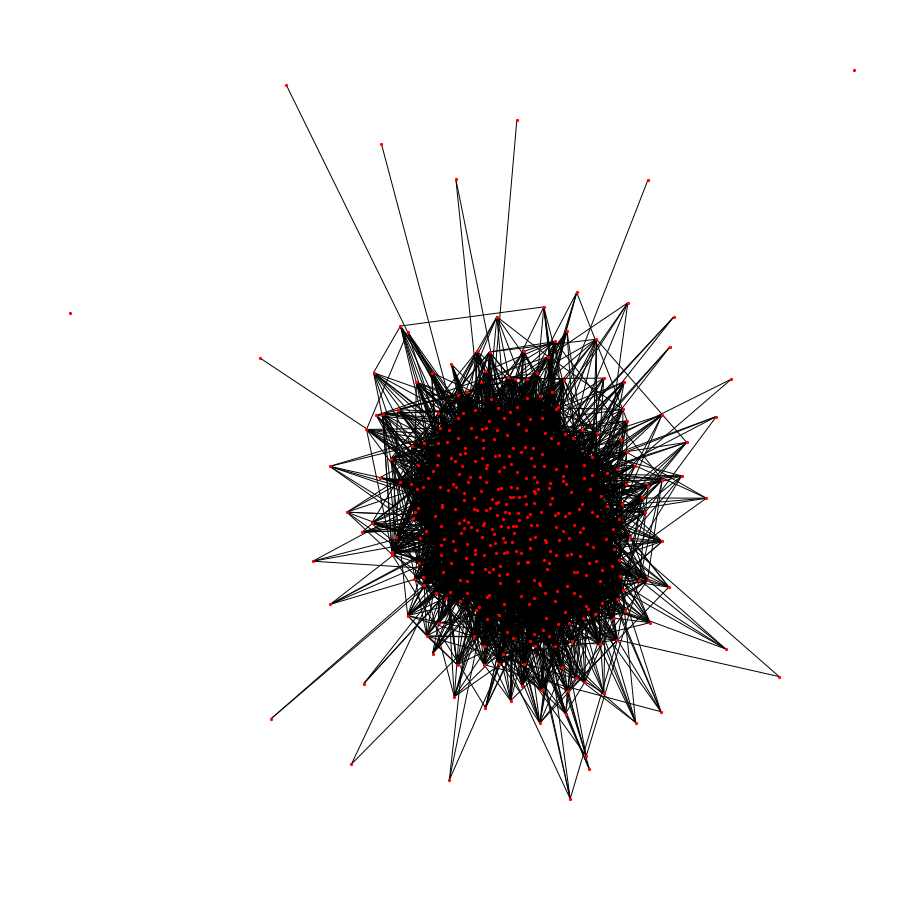

In [68]:
#Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_spring(pp_G, node_size = 5)
plt.show()

In [13]:
#Write entire graph to disk
#nx.write_gpickle(pp_G, 'pp-graph')

In [30]:
#Load graph from disk
pp_G = nx.read_gpickle('pp-graph')

We can now analyse the graph before diving into clustering.

[Back to top](#index)

<a id='ppanalysis'></a>

## 3.B Analysis

First we will analyse the isolated nodes. <br>
Then we will look at the degree distribution and the adjacency matrix. <br>

In [69]:
def analyse_isolation_graph(graph):
    #Degree distribution
    player_degrees = nx.degree(graph)
    degrees = np.sort(list(player_degrees.values()))
    
    #Number of 0 degree node
    nb_zeros = np.count_nonzero(degrees==0)
    print('Number of isolated nodes : ', nb_zeros, ' (', round(nb_zeros*100/len(degrees),2), '%)')
    
    
    #Giant Component analysis 
    largest_cc = max(nx.connected_components(graph), key=len)
    nb_components = nx.number_connected_components(graph)
    print('Giant Component represents ', len(largest_cc),' nodes (', \
          round(len(largest_cc)/len(graph.nodes()),2),'%)')
    print('There are ', nb_components, ' components (', nb_components- nb_zeros, \
          ' without isolated nodes)')
    
    #Clustering coefficient
    print('The average clustering coefficient is : ', nx.average_clustering(graph))

In [35]:
analyse_isolation_graph(pp_G)

Number of isolated nodes :  2  ( 0.48 %)
Giant Component represents  411  nodes ( 1.0 %)
There are  3  components ( 1  without isolated nodes)
The average clustering coefficient is :  0.30483895909574277


#### Removing players with no connections (and team-connections)

We want to remove all the players from the graph that have no connections with the rest of the players and also the ones that have no connections with their corresponding team mates as those players correspond to "noise" in the graph 

What we call team-connections are the links between players from the same team

In [70]:
def get_connections_from_team(players_2017, twitter_player, full_graph):
    '''Get set of players from the same team AND friends on twitter with the wanted player'''
    # Get team name of the player
    team_name = list(players_2017[players_2017['Twitter_name'] == twitter_player]['Team'])[0]
    # Get team mates of the player
    team_players = set(players_2017[players_2017['Team'] == team_name]['Twitter_name'])
    # Gettwitter connections with other NBA players
    player_connections = set(full_graph.neighbors(twitter_player))
    # Return intersection of 2 sets
    return team_players.intersection(player_connections)

In [71]:
players_2017['connections'] = [len(pp_G.neighbors(node)) for node in list(players_2017['Twitter_name'])]
players_2017['team_connections'] = [len(get_connections_from_team(players_2017, node, pp_G)) for node in list(players_2017['Twitter_name'])]

In [72]:
players_2017.head()

Team    Twitter_name                  Wiki  \
Name                                                                   
Kadeem Allen    Boston Celtics    @AllenKadeem    /wiki/Kadeem_Allen   
Aron Baynes     Boston Celtics     @aronbaynes     /wiki/Aron_Baynes   
Jabari Bird     Boston Celtics     @JabariBird     /wiki/Jabari_Bird   
Jaylen Brown    Boston Celtics         @FCHWPO    /wiki/Jaylen_Brown   
Gordon Hayward  Boston Celtics  @gordonhayward  /wiki/Gordon_Hayward   

                         Division          Conference  connections  \
Name                                                                 
Kadeem Allen    Atlantic Division  EASTERN CONFERENCE            6   
Aron Baynes     Atlantic Division  EASTERN CONFERENCE           22   
Jabari Bird     Atlantic Division  EASTERN CONFERENCE            3   
Jaylen Brown    Atlantic Division  EASTERN CONFERENCE           43   
Gordon Hayward  Atlantic Division  EASTERN CONFERENCE           39   

                team_connections  
Name                              
Kadeem Allen                   1  
Aron Baynes                    3  
Jabari Bird                    0  
Jaylen Brown                   5  
Gordon Hayward                 6

In [95]:
def clean_isolated_nodes(graph, players_2017):
    players_2017['connections'] = [len(graph.neighbors(node)) for node in list(players_2017['Twitter_name'])]
    players_2017['team_connections'] = [len(get_connections_from_team(players_2017, node, graph)) for node in list(players_2017['Twitter_name'])]
    
    #Check users with no connections:
    players_no_connections = players_2017[players_2017['connections'] == 0]
    # Need to get all connections to have true results
    print("There are {} players with no connections from {} total players".format(len(players_no_connections), len(players_2017)))

    #Remove the players with no connections from the graph:
    names = players_no_connections.index.values
    players_2017.drop(names, inplace=True)
    graph.remove_nodes_from(players_no_connections["Twitter_name"].tolist())
    
    #Check users with no TEAM-connections:
    players_no_team_connections = players_2017[players_2017['team_connections'] == 0]
    # Need to get all connections to have true results
    print("There are {} players with no team connections from {} total players".format(len(players_no_team_connections), len(players_2017)))

    #Remove the players with no team connections from the graph:
    names = players_no_team_connections.index.values
    players_2017.drop(names, inplace=True)
    graph.remove_nodes_from(players_no_team_connections["Twitter_name"].tolist())
    #return players_no_connections, players_no_team_connections

In [74]:
clean_isolated_nodes(pp_G, players_2017)

There are 2 players with no connections from 413 total players
There are 29 players with no team connections from 411 total players


In [57]:
east_players, west_players, division_players, team_players = update_ground_truth(players_2017)

We display below some data from intermediary dataframes from the cleaning of isolated nodes : 

In [75]:
#players_no_connections.head()

Team    Twitter_name                Wiki  \
Name                                                                   
Julyan Stone   Charlotte Hornets  @julyanrcstone  /wiki/Julyan_Stone   
Otto Porter   Washington Wizards     @OttoPorter   /wiki/Otto_Porter   

                        Division          Conference  connections  \
Name                                                                
Julyan Stone  Southeast Division  EASTERN CONFERENCE            0   
Otto Porter   Southeast Division  EASTERN CONFERENCE            0   

              team_connections  
Name                            
Julyan Stone                 0  
Otto Porter                  0

In [76]:
#players_no_team_connections.head()

Team      Twitter_name                  Wiki  \
Name                                                                         
Jabari Bird         Boston Celtics       @JabariBird     /wiki/Jabari_Bird   
Ramon Sessions     New York Knicks    @SessionsRamon  /wiki/Ramon_Sessions   
Trevor Booker   Philadelphia 76ers          @35_Fitz   /wiki/Trevor_Booker   
Furkan Korkmaz  Philadelphia 76ers  @FurkanKorkmazFK  /wiki/Furkan_Korkmaz   
J. J. Redick    Philadelphia 76ers         @JRedick4    /wiki/J._J._Redick   

                         Division          Conference  connections  \
Name                                                                 
Jabari Bird     Atlantic Division  EASTERN CONFERENCE            3   
Ramon Sessions  Atlantic Division  EASTERN CONFERENCE           10   
Trevor Booker   Atlantic Division  EASTERN CONFERENCE           29   
Furkan Korkmaz  Atlantic Division  EASTERN CONFERENCE            1   
J. J. Redick    Atlantic Division  EASTERN CONFERENCE            9   

                team_connections  
Name                              
Jabari Bird                    0  
Ramon Sessions                 0  
Trevor Booker                  0  
Furkan Korkmaz                 0  
J. J. Redick                   0

We can have a look once again at the graph : 

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

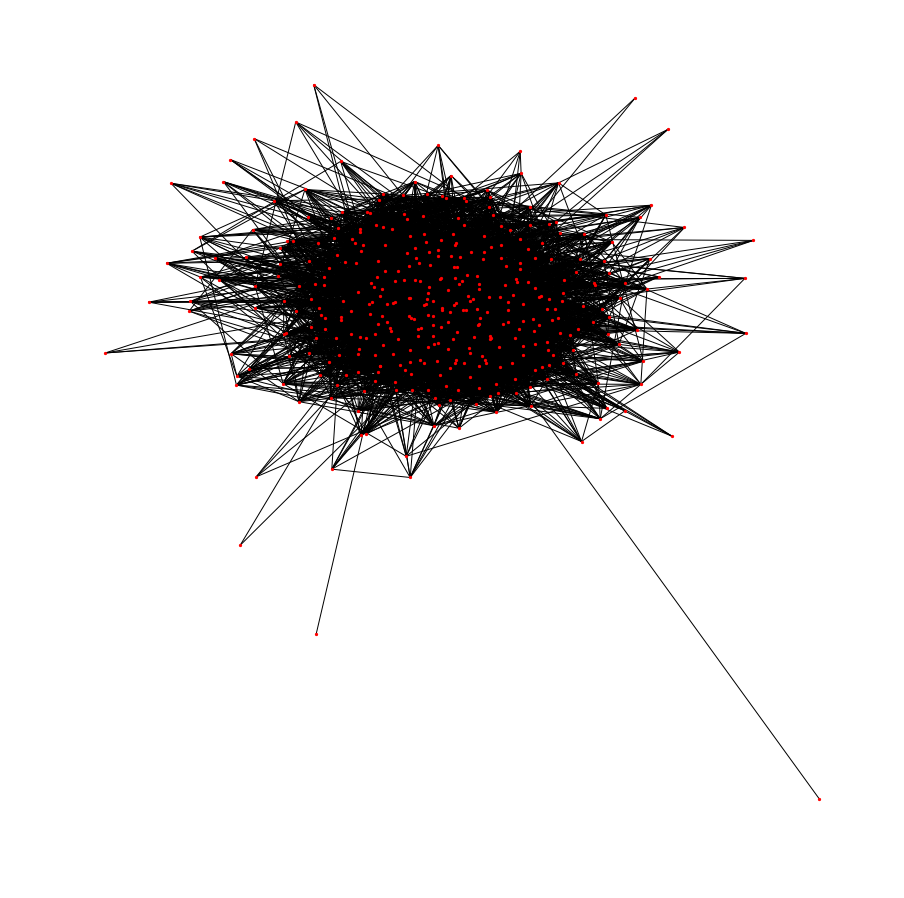

In [42]:
plt.figure(figsize=(12, 12))
nx.draw_spring(pp_G, node_size = 5)
plt.show()

In [93]:
def get_names_from_twitter(twitters):
    names = []
    for t in twitters:
        names.append(players_2017[players_2017['Twitter_name'] == t].index.tolist())
    return sum(names, [])

In [92]:
def analyse_degree_distribution(graph):
    #Diameter
    print('The diameter of this graph is : ', nx.diameter(graph))
    
    #Degree distribution
    player_degrees = nx.degree(graph)
    degrees = np.sort(list(player_degrees.values()))

    fig = plt.figure()
    fig.set_size_inches(12, 12)

    plt.subplot(221)
    plt.plot(range(0, len(degrees)), degrees[::-1])
    plt.ylabel('Degree of player node')
    plt.xlabel('Player node')
    plt.title('Degree distribution')

    plt.subplot(222)
    plt.hist(degrees, bins = range(0, 200, 3), rwidth = 0.8)
    plt.xlabel('Degree of player node')
    plt.ylabel('Number of player nodes')
    plt.title('Histogram of degree distribution')

    plt.subplot(223)
    plt.spy(nx.adj_matrix(graph), markersize=1)
    plt.xlabel('Player node')
    plt.ylabel('Player node')
    plt.title('Adjacency matrix')

    plt.subplot(224)
    plt.boxplot(degrees)
    plt.xlabel('Degree distribution')

    plt.show()
    
    #Find cliques in graph
    cliques = nx.find_cliques(graph)
    largest_clique = max(cliques, key=len)
    print('The largest clique of this graph is composed of the players : ',
          get_names_from_twitter(largest_clique))

The diameter of this graph is :  4


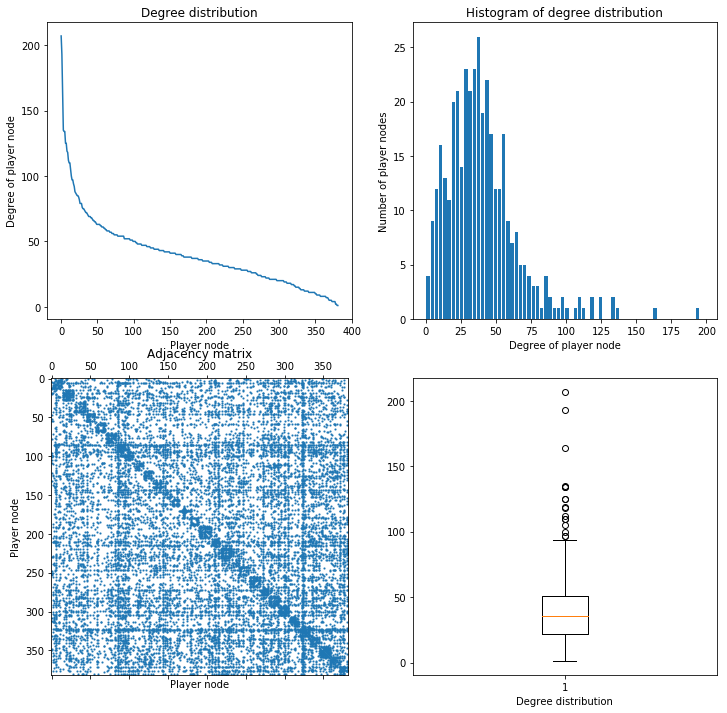

The largest clique of this graph is composed of the players :  ['Kevin Durant', 'LeBron James', 'Chris Paul', 'Dwyane Wade', 'Russell Westbrook', 'Jamal Crawford', 'Carmelo Anthony', 'Blake Griffin', 'Rudy Gay', 'Dwight Howard', 'Stephen Curry', 'J. R. Smith', 'Evan Turner', 'Eric Gordon', 'Michael Carter-Williams', 'Paul George']


In [45]:
analyse_degree_distribution(pp_G)

From the adjacency matrix, we can observe some team clusters on the diagonal but the overall graph is not sparse and the clustering might be difficult as we will see in the next sub-section. This "non sparsity" is explaines by the fact that players are connected to a lot of other players (not only from their own team, conference or division): from the degree distribution graph, we see that one fourth of players (100) are linked to more than 50 other players

In this clique we recognize the following All star players : Lebron James, Dwayne Wade, Carmelo Anthony, Chris Paul, Kevin Durant, Dwight Howard, Russell Westbrook, Blake Griffin, Stephen Curry, Paul George.  <br>
Source : https://en.wikipedia.org/wiki/List_of_NBA_All-Stars

Display for each team the ratio of team connections compared to the total connections from members of the team:

In [105]:
def update_team_connectivity(teams, players_2017):
    # Create dictionary with team name as key and a tuple as value:
    #(total number of connections inside team, total number of connections from team members)
    team_connections = {}
    for i, player in players_2017.iterrows():
        team = player['Team']
        player_team_co = player['team_connections']
        player_full_co = player['connections']
        if team in team_connections.keys():
            team_co = team_connections[team]
            team_connections[team] = [team_co[0] + player_team_co, team_co[1] + player_full_co]
        else:
            team_connections[team] = [player_team_co, player_full_co]
    
    teams['number_players'] = [len(players_2017[players_2017['Team'] == team]) for team in list(teams['Team'])]
    teams['team_connections_ratio'] = [str((team_connections[team][0]/team_connections[team][1])*100) + ' %' for team in list(teams['Team'])]
    
    ratios = [((team_connections[team][0]/team_connections[team][1])*100) for team in list(teams['Team'])]
    print("The average of player connections to players from the same team is {} %".format(np.mean(ratios)))

In [45]:
update_team_connectivity(teams, players_2017)

The average of player connections to players from the same team is 14.386519228022712 %


In [98]:
#We display here example of the intermediary results
#team_connections['Boston Celtics']

[72, 506]

In [100]:
#Intermediate result
#teams.head(10)

Team          Twitter  \
Conference         Division                                                  
EASTERN CONFERENCE Atlantic Division       Boston Celtics         @celtics   
                   Atlantic Division        Brooklyn Nets    @BrooklynNets   
                   Atlantic Division      New York Knicks        @nyknicks   
                   Atlantic Division   Philadelphia 76ers          @Sixers   
                   Atlantic Division      Toronto Raptors         @raptors   
                   Central Division         Chicago Bulls    @chicagobulls   
                   Central Division   Cleveland Cavaliers            @cavs   
                   Central Division       Detroit Pistons  @detroitpistons   
                   Central Division        Indiana Pacers          @Pacers   
                   Central Division       Milwaukee Bucks           @Bucks   

                                      number_players team_connections_ratio  
Conference         Division                                                  
EASTERN CONFERENCE Atlantic Division              15   14.229249011857709 %  
                   Atlantic Division              15   17.940199335548172 %  
                   Atlantic Division              16   13.986013986013987 %  
                   Atlantic Division              15   16.176470588235293 %  
                   Atlantic Division              15   21.142857142857142 %  
                   Central Division               15    18.64406779661017 %  
                   Central Division               13                9.375 %  
                   Central Division               11   11.182795698924732 %  
                   Central Division               14   11.707317073170733 %  
                   Central Division               13   13.071895424836603 %

From the above results of the teams dataframe (computed using the graph and removing some unwanted connection), we clearly see that in average, each player has more links with players from the other teams rather from his own team. It seems logical as there are only between 9 and 15 other players in the same team of a specific player and a lot more outside his team (around 350).

To estimate how well we can cluster the points, let's visualize the data with PCA on 2 and 3 dimensions for each level :

In [46]:
def visualize_pca(graph, players_2017):
    #PCA visualization with dimension = 2
    coords_2D = get_pca_coords(graph, 2)
    genres = np.array(preprocessing.LabelEncoder().fit_transform(players_2017['Conference']))
    plt.scatter(coords_2D[:, 0], coords_2D[:, 1], c=genres, cmap='RdBu', alpha=0.5)
    plt.title('Conference Level on 2 dimensions')
    
    #PCA visualization with dimension = 3
    coords_3D = get_pca_coords(graph, 3)
    genres = preprocessing.LabelEncoder().fit_transform(players_2017['Conference'])
    fig_3D = plt.figure()
    ax_3D = Axes3D(fig_3D)
    ax_3D.scatter(coords_3D[:, 0], coords_3D[:, 1], coords_3D[:, 2], c=genres, cmap='RdBu', alpha=0.5)
    plt.title('Conference Level on 3 dimensions')
    plt.show()
    
    #PCA visualization with dimension = 2
    genres = preprocessing.LabelEncoder().fit_transform(players_2017['Division'])
    plt.scatter(coords_2D[:, 0], coords_2D[:, 1], c=genres, cmap='tab10', alpha=0.5);
    plt.title('Division Level on 2 dimensions')
    
    #PCA visualization with dimension = 3
    genres = preprocessing.LabelEncoder().fit_transform(players_2017['Division'])
    fig_3D = plt.figure()
    ax_3D = Axes3D(fig_3D)
    ax_3D.scatter(coords_3D[:, 0], coords_3D[:, 1], coords_3D[:, 2], c=genres, cmap='tab10', alpha=0.5)
    plt.title('Division Level on 3 dimensions')
    plt.show()
    
    #PCA visualization with dimension = 2
    genres = preprocessing.LabelEncoder().fit_transform(players_2017['Team'])
    plt.scatter(coords_2D[:, 0], coords_2D[:, 1], c=genres, cmap='gist_rainbow', alpha=0.5);
    plt.title('Team Level on 2 dimensions')

    #PCA visualization with dimension = 3
    genres = preprocessing.LabelEncoder().fit_transform(players_2017['Team'])
    fig_3D = plt.figure()
    ax_3D = Axes3D(fig_3D)
    ax_3D.scatter(coords_3D[:, 0], coords_3D[:, 1], coords_3D[:, 2], c=genres, cmap='gist_rainbow', alpha=0.5)
    plt.title('Team Level on 3 dimensions')
    plt.show()

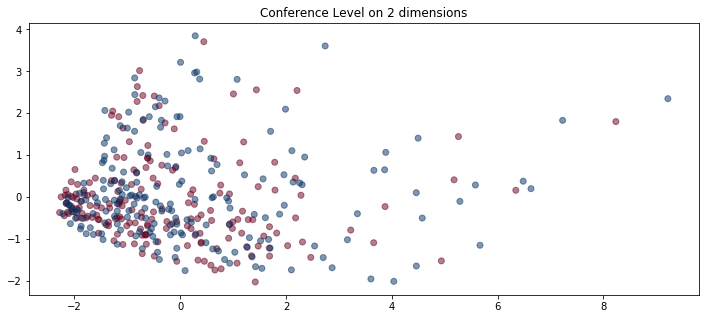

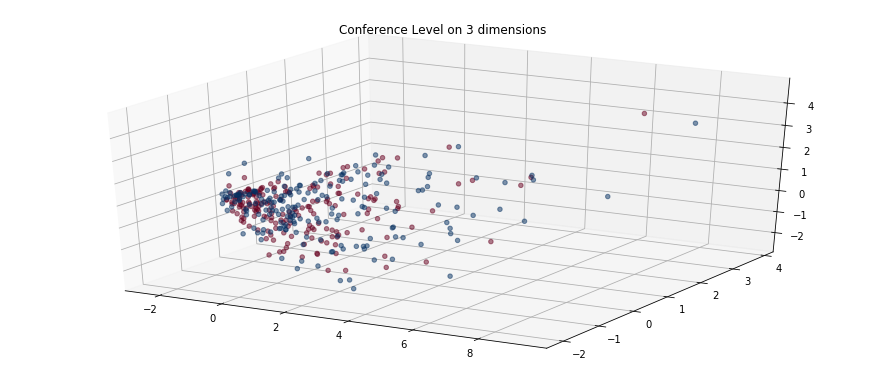

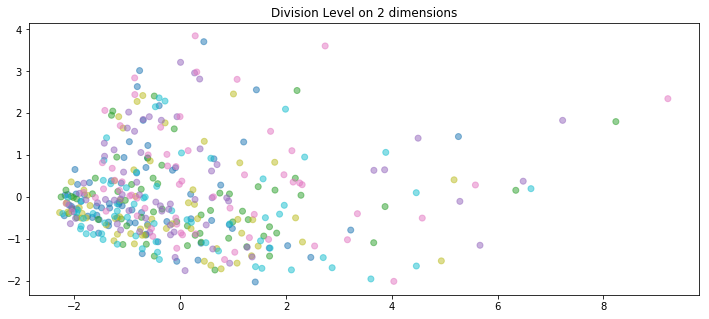

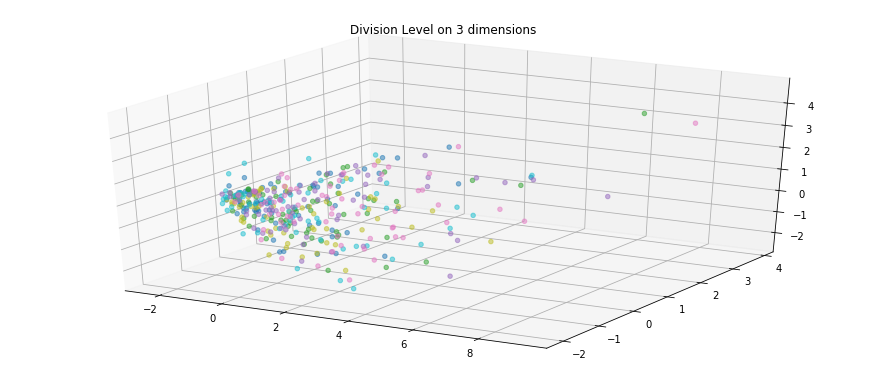

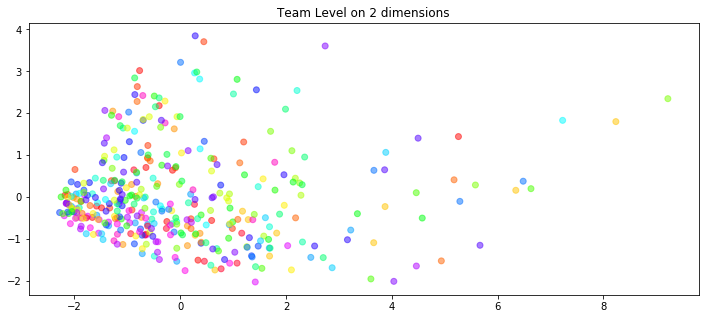

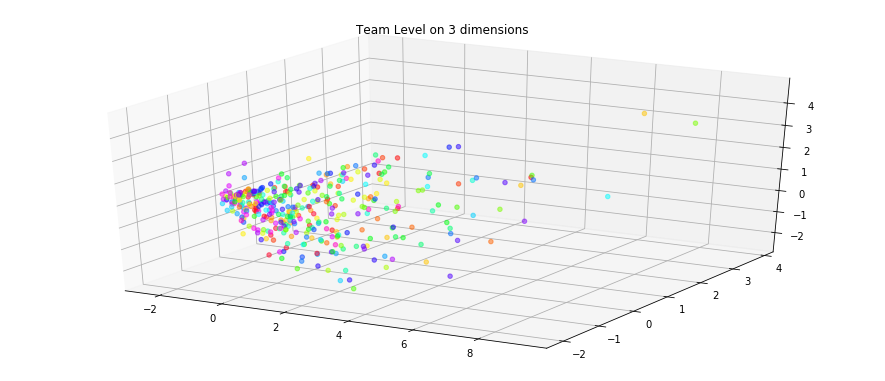

In [47]:
visualize_pca(pp_G, players_2017)

For any level (Team, Division or Conference), we can assume that the clustering will be hard as the points of different colors, meaning different teams/divisions/conferences are hard to differentiate and don't really form distinct clusters in the 2-D and 3-D PCA. 

[Back to top](#index)

<a id='ppconf'></a>

## 3.C Cluster at conference level

Number of clusters : 2 (EASTERN and WESTERN Conferences)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:24<00:00,  3.84s/it]


The number of correct attribution of clusters is  100  over  100


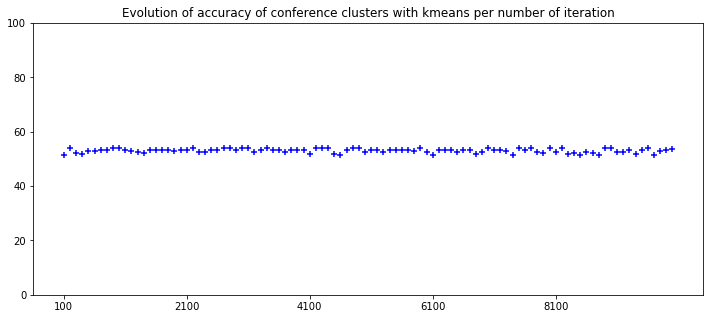

The best value was with  200 iterations giving accuracy :  53.93


In [48]:
#With kmeans
compute_kmeans(pp_G, 'conference', 2, nx.to_numpy_matrix(pp_G),np.linspace(100, 1e4, 100, dtype=int))

K-means technique gives results slightly better then random labelling.

In [116]:
#With DBSCAN
_ , dbscan_labels = apply_dbscan(nx.to_numpy_matrix(pp_G), 10)
set(dbscan_labels) #-1 is for unclear

{-1, 0}

The DBSCAN technique seems to find only one cluster and some unclear points --> We will stop using this method.

In [122]:
#With Spectral Clustering
labels = apply_spectral(nx.to_numpy_matrix(pp_G), 2)
clusters, nb_clusters = compute_names_per_cluster(labels, 2, pp_G)
compute_accuracy(clusters, 2, pp_G)

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


('ERROR : Unclear attribution', 0)

In [54]:
#With PCA and kmeans
tab_pca_coords = []
for d in range(2,51):
    coords = get_pca_coords(pp_G, d)
    tab_pca_coords.append(coords)

In [128]:
tab_pca_conf_best = []
tab_pca_conf_acc = []
for coords in tab_pca_coords:
    pca_res = compute_pca_kmeans(pp_G, 'conference', 2, coords, np.linspace(10, 1e4, 20, dtype=int), False)
    tab_pca_conf_best.append(pca_res[0])
    tab_pca_conf_acc.append(pca_res[1])

 15%|█▌        | 3/20 [00:00<00:00, 19.73it/s]

The number of correct attribution of clusters is  20  over  20


 15%|█▌        | 3/20 [00:00<00:00, 18.56it/s]

The number of correct attribution of clusters is  20  over  20


 15%|█▌        | 3/20 [00:00<00:01, 15.44it/s]

The number of correct attribution of clusters is  20  over  20


 15%|█▌        | 3/20 [00:00<00:01, 15.37it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:00, 19.71it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:01, 17.26it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:01, 16.93it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


  0%|          | 0/20 [00:00<?, ?it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:00, 18.11it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:00, 18.98it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:00, 19.27it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:01, 16.50it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:00, 18.69it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:00, 18.32it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:01, 16.56it/s]

The number of correct attribution of clusters is  20  over  20


 10%|█         | 2/20 [00:00<00:00, 19.41it/s]

The number of correct attribution of clusters is  20  over  20


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]

The number of correct attribution of clusters is  20  over  20


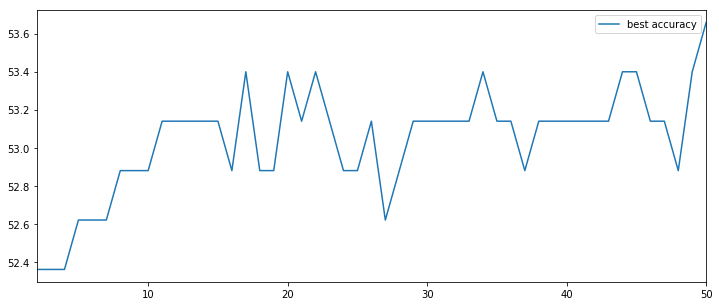

In [129]:
df_pca_conf_best = pd.DataFrame(tab_pca_conf_best, columns=['best accuracy'])
df_pca_conf_best.index = list(range(2,51))
df_pca_conf_best.plot()
plt.show()

Best case is with dimension 50 giving accuracy of 53.66% which is just a bit better than with 2D or 3D PCA giving around 52.4%. It is a bit worse than using k-means for which we obtained 53.93%

Best case is with dimension 50 giving accuracy 53.66


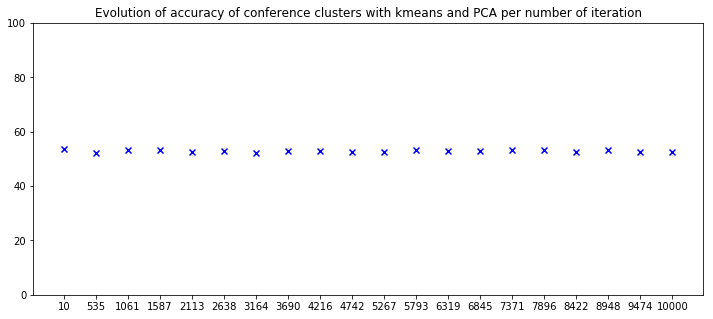

In [130]:
print('Best case is with dimension {} giving accuracy {}'.format(df_pca_conf_best['best accuracy'].idxmax(),df_pca_conf_best['best accuracy'].max()))

plot = plt.scatter(np.linspace(10, 1e4, 20, dtype=int), tab_pca_conf_acc[df_pca_conf_best['best accuracy'].idxmax()-2], c = 'b', marker = 'x')
plt.xticks(np.linspace(10, 1e4, 20, dtype=int))
plt.ylim((0, 100))
plt.title('Evolution of accuracy of conference clusters with kmeans and PCA per number of iteration')
plt.show()

In [49]:
#With GMM
labels = apply_GMM(nx.to_numpy_matrix(pp_G), 2, 100)
clusters, nb_clusters = compute_names_per_cluster(labels, 2, pp_G)
compute_accuracy(clusters, nb_clusters, pp_G)

(53.14, 1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.93it/s]


The number of correct attribution of clusters is  100  over  100


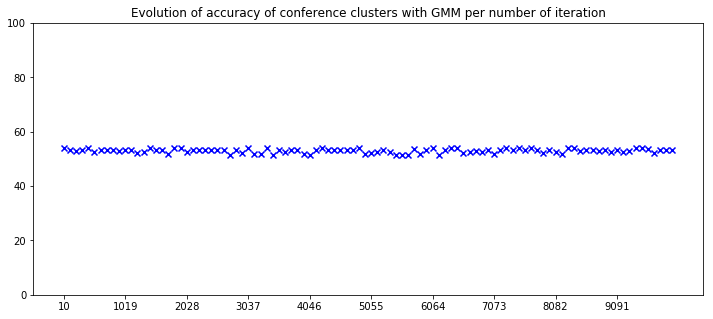

The best value was with  10 iterations giving accuracy :  53.93


In [50]:
compute_GMM(pp_G, 'conference', 2, nx.to_numpy_matrix(pp_G), np.linspace(10, 1e4, 100, dtype=int))

##### Best results : 
GMM and K-Means giving accuracy :  53.93% which is slightly better than a random assignment as there are only 2 conferences. We conclude that the graph does not give much information on determining the 2 conferences based on clustering

<a id='ppdiv'></a>

[Back to top](#index)

## 3.D Cluster at Division level

Number of clusters : 6

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:30<00:00,  4.50s/it]


The number of correct attribution of clusters is  5  over  100


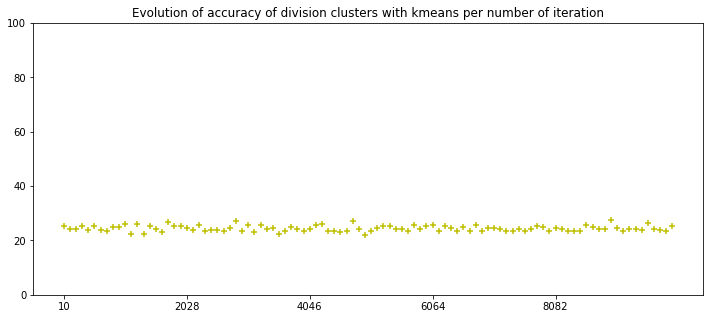

The best value was with  8990 iterations giving accuracy :  27.49


In [51]:
#With kmeans
compute_kmeans(pp_G, 'division', 6, nx.to_numpy_matrix(pp_G), np.linspace(10, 1e4, 100, dtype=int))

In [52]:
#With Spectral clustering
labels = apply_spectral(nx.to_numpy_matrix(pp_G), 6)
clusters, nb_clusters = compute_names_per_cluster(labels, 6, pp_G)
compute_accuracy(clusters, nb_clusters, pp_G)

C:\Users\olivi\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


(19.629999999999999, 0)

In [55]:
#With PCA and kmeans
tab_pca_div_best = []
tab_pca_div_acc = []
for coords in tab_pca_coords:
    pca_res = compute_pca_kmeans(pp_G, 'division', 6, coords, np.linspace(10, 1e4, 20, dtype=int), False)
    tab_pca_div_best.append(pca_res[0])
    tab_pca_div_acc.append(pca_res[1])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.35it/s]


The number of correct attribution of clusters is  1  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.25it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.28it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.19it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.15it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.15it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.09s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.10s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.09s/it]


The number of correct attribution of clusters is  2  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]


The number of correct attribution of clusters is  1  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]


The number of correct attribution of clusters is  1  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


The number of correct attribution of clusters is  1  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.40s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.55s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.43s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.44s/it]


The number of correct attribution of clusters is  2  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


The number of correct attribution of clusters is  1  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.42s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]


The number of correct attribution of clusters is  1  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


The number of correct attribution of clusters is  0  over  20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


The number of correct attribution of clusters is  0  over  20


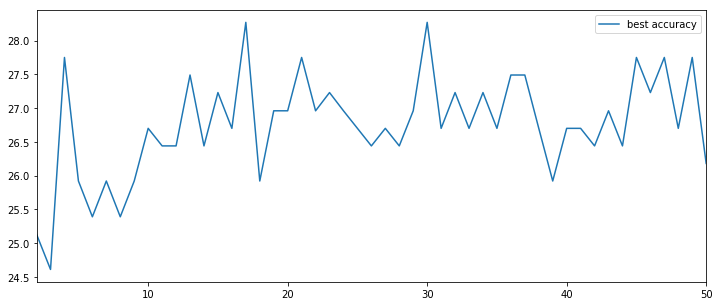

In [57]:
df_pca_div_best = pd.DataFrame(tab_pca_div_best, columns=['best accuracy'])
df_pca_div_best.index = list(range(2,51))
df_pca_div_best.plot()
plt.show()

Best case is with dimension 17 giving accuracy 28.27%


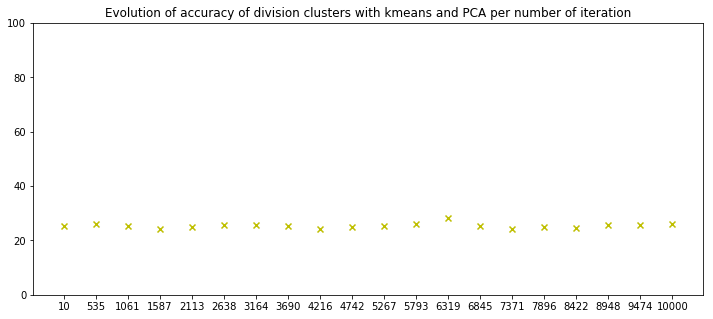

In [64]:
print('Best case is with dimension {} giving accuracy {}%'.format(df_pca_div_best['best accuracy'].idxmax(),df_pca_div_best['best accuracy'].max()))
#compute_pca_kmeans('conference', 2, pca_conf_coords, np.logspace(1, 4, 20, dtype=int), True)
plot = plt.scatter(np.linspace(10, 1e4, 20, dtype=int), tab_pca_div_acc[df_pca_div_best['best accuracy'].idxmax()-2], c = 'y', marker = 'x')
plt.xticks(np.linspace(10, 1e4, 20, dtype=int))
plt.ylim((0, 100))
plt.title('Evolution of accuracy of division clusters with kmeans and PCA per number of iteration')
plt.show()

In [61]:
#With GMM
labels = apply_GMM(nx.to_numpy_matrix(pp_G), 6, 20)
clusters, nb_clusters = compute_names_per_cluster(labels,6, pp_G)
compute_accuracy(clusters, nb_clusters, pp_G)

(24.079999999999998, 0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


The number of correct attribution of clusters is  1  over  100


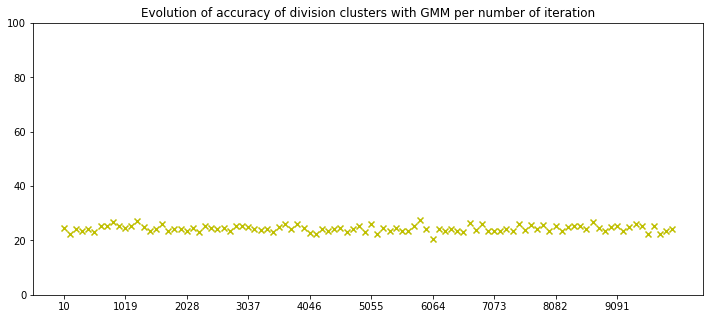

The best value was with  5862 iterations giving accuracy :  27.49


In [62]:
compute_GMM(pp_G, 'division', 6, nx.to_numpy_matrix(pp_G), np.linspace(10, 1e4, 100, dtype=int))

##### Best results : 
K-means and GMM giving accuracy :  27.49%. This accuracy is actually better than random attribution of a player to a cluster as there are 6 divisions, meaning the random accuracy would be $\frac{100}{6} = 16.6\% $.

<a id='ppteam'></a>

[Back to top](#index)

## 3.E Cluster at Team level

Number of clusters : 30

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:09<00:00,  6.69s/it]


The number of correct attribution of clusters is  0  over  100


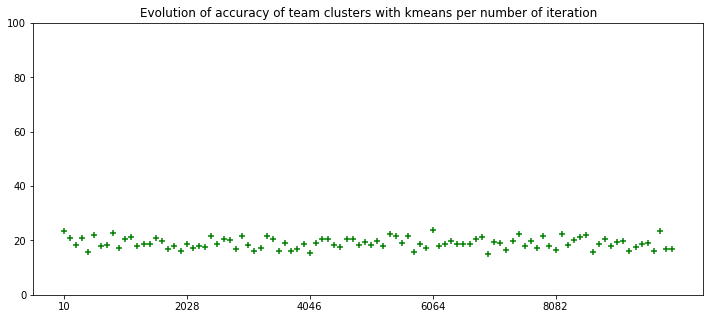

The best value was with  6064 iterations giving accuracy :  23.82


In [63]:
#With kmeans
compute_kmeans(pp_G, 'team', 30, nx.to_numpy_matrix(pp_G), np.linspace(10, 1e4, 100, dtype=int))

In [146]:
#With Spectral clustering
labels = apply_spectral(nx.to_numpy_matrix(pp_G), 30)
clusters, nb_clusters = compute_names_per_cluster(labels, 30, pp_G)
compute_accuracy(clusters, nb_clusters, pp_G)

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


(11.52, 0)

In [ ]:
#With PCA and kmeans
tab_pca_team_best = []
tab_pca_team_acc = []
for coords in tab_pca_coords:
    pca_res = compute_pca_kmeans(pp_G, 'team', 30, coords, np.linspace(10, 1e4, 20, dtype=int), False)
    tab_pca_team_best.append(pca_res[0])
    tab_pca_team_acc.append(pca_res[1])

In [ ]:
df_pca_team_best = pd.DataFrame(tab_pca_team_best, columns=['best accuracy'])
df_pca_team_best.index = list(range(2,51))
df_pca_team_best.plot()
plt.show()

In [ ]:
print('Best case is with dimension {} giving accuracy {}'.format(df_pca_team_best['best accuracy'].idxmax(),df_pca_team_best['best accuracy'].max()))

#compute_pca_kmeans('conference', 2, pca_conf_coords, np.logspace(1, 4, 20, dtype=int), True)
plot = plt.scatter(np.linspace(10, 1e4, 100, dtype=int), tab_pca_team_acc[df_pca_team_best['best accuracy'].idxmax()-2], c = 'g', marker = 'x')
plt.xticksnp.linspace(10, 1e4, 100, dtype=int))
plt.ylim((0, 100))
plt.title('Evolution of accuracy of team clusters with kmeans and PCA per number of iteration')
plt.show()

In [148]:
#With GMM
labels = apply_GMM(nx.to_numpy_matrix(pp_G), 30, 100)
clusters, nb_clusters = compute_names_per_cluster(labels, 30, pp_G)
compute_accuracy(clusters, nb_clusters, pp_G)

(19.629999999999999, 0)

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


The number of correct attribution of clusters is  0  over  20


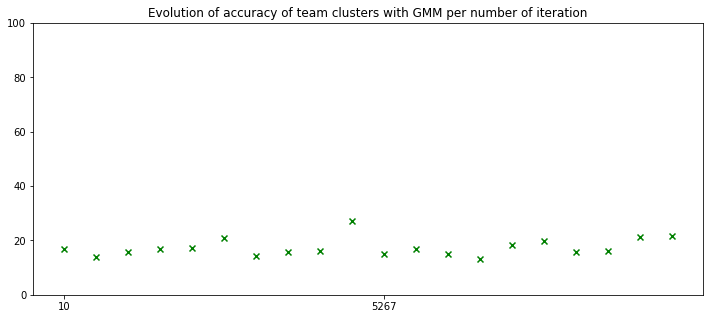

The best value was with  4742 iterations giving accuracy :  27.23


In [149]:
compute_GMM(pp_G, 'team', 30, nx.to_numpy_matrix(pp_G), np.linspace(10, 1e4, 20, dtype=int))

##### Best results : 
GMM giving accuracy : 27.23% which is way better than a random assignment of a player to one of the random 30 teams. One fourth of the players are assigned to their correct team, whether it would be $\frac{100}{30} = 3.33\%$ if random

[Back to top](#index)

<a id='optimal'></a>

## 3.F Optimal Graph Analysis

In this part, we will try to analyse deeper why we can't reach nice clustering results with our graph. <br>
Our idea is to remove every "noise" edge from our graph. We will remove every edge accross different clusters (eg: all the edges linking the 2 conferences). This will give us the upper bound of the accuracy that we could get with the twitter data. <br>
Then we will progressively add some of the edges to see the evolution of the accuracy in function of the "noise" edges quantity.

#### Conference Level

In [67]:
def create_conf_graph(conf_name, full_graph, node_color, show = True):
    '''Create a graph between players of the same conference based on the full NBA graph'''
    conf_graph = nx.Graph()
    all_edges = full_graph.edges()
    # Get players twitter from the team 
    conf_players = [east_players if conf_name == 'east' else west_players] 
    #print(conf_players[0])
    # Append nodes in graph:
    conf_graph.add_nodes_from(conf_players[0])
    # Append edges in graph
    for edge in all_edges:
        if edge[0] in conf_players[0] and edge[1] in conf_players[0]:
            conf_graph.add_edge(edge[0], edge[1])
    # Draw graph
    if show:
        plt.figure(figsize=(7, 7))
        nx.draw(conf_graph, node_color = node_color, node_size = 10)
        plt.show()
    return conf_graph

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

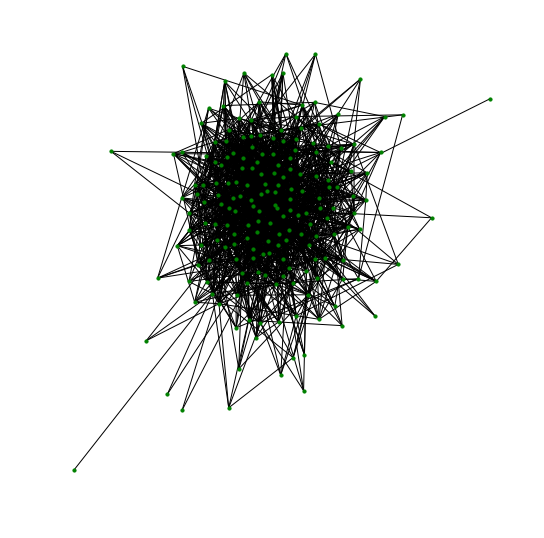

In [68]:
east_graph = create_conf_graph('east', pp_G, 'green')

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

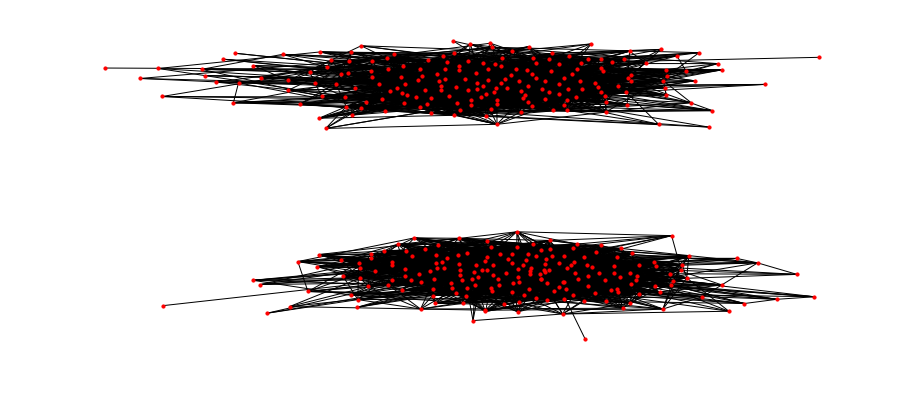

In [69]:
west_graph = create_conf_graph('west', pp_G, 'blue', show = False)
east_graph.remove_nodes_from(nx.isolates(east_graph))
west_graph.remove_nodes_from(nx.isolates(west_graph))
conf_graph = nx.compose(east_graph, west_graph)
nx.draw(conf_graph, node_size = 10)

In [70]:
pp_G_nb_edges = pp_G.number_of_edges()
def edges_deletion(new_nb_edges, level):
    nb_delete = pp_G_nb_edges - new_nb_edges
    print('This ', level ,' graph has ', new_nb_edges,'edges')
    print('We have then deleted ', nb_delete , 'edges (', 
          round(nb_delete*100/pp_G_nb_edges,2), '%)' )

In [71]:
edges_deletion(conf_graph.number_of_edges(), 'conference')

This  conference  graph has  4377 edges
We have then deleted  3308 edges ( 43.04 %)


#### Division Level

In [72]:
def create_div_graph(div_name, full_graph, node_color, show = True):
    '''Create a graph between players of the same division based on the full NBA graph'''
    div_graph = nx.Graph()
    all_edges = full_graph.edges()
    # Get players twitter from the team 
    div_players = set(players_2017[players_2017['Division'] == div_name]['Twitter_name'])
    # Append nodes in graph:
    div_graph.add_nodes_from(div_players)
    # Append edges in graph
    for edge in all_edges:
        if edge[0] in div_players and edge[1] in div_players:
            div_graph.add_edge(edge[0], edge[1])
    # Draw graph
    if show:
        plt.figure(figsize=(7, 7))
        nx.draw(div_graph, node_color = node_color, node_size = 10)
        plt.show()
    return div_graph

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

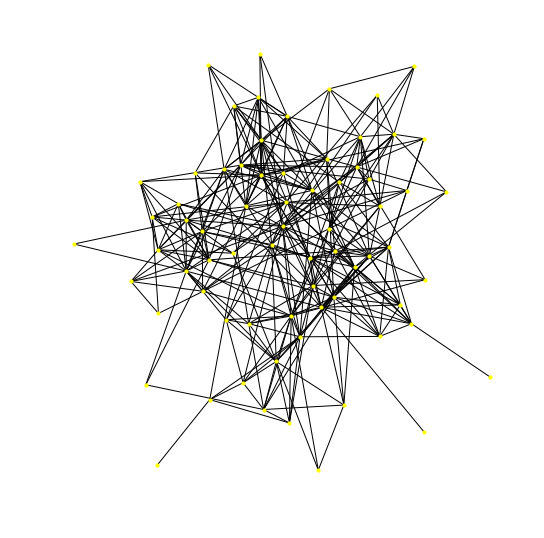

In [73]:
altantic_graph = create_div_graph('Atlantic Division', pp_G, 'yellow')

In [74]:
def create_opt_div_graph(divs, original_graph, show = True):
    full_graph = nx.Graph()
    for d in divs:
        div_graph = create_div_graph(d, original_graph, "red", show = False)
        full_graph = nx.compose(div_graph, full_graph)
    if show:
        plt.figure(figsize=(7, 7))
        nx.draw(full_graph, node_size = 10)
        plt.show()
    return full_graph

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

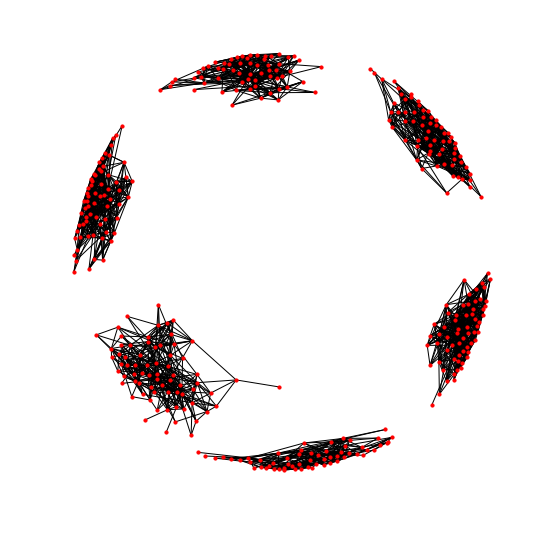

6


In [75]:
divs_name = set(teams.index.get_level_values('Division'))
opt_div_graph = create_opt_div_graph(divs_name, pp_G)
print(nx.number_connected_components(opt_div_graph))

In [76]:
edges_deletion(opt_div_graph.number_of_edges(), 'division')

This  division  graph has  2046 edges
We have then deleted  5639 edges ( 73.38 %)


#### Team Level
Create individual team graphs in order to build the perfect graph:

In [77]:
def create_team_graph(team_name, full_graph, node_color, show = True):
    '''Create a team graph between players of the same team based on the full NBA graph'''
    team_graph = nx.Graph()
    all_edges = full_graph.edges()
    # Get players twitter from the team 
    team_players = set(players_2017[players_2017['Team'] == team_name]['Twitter_name'])
    # Append nodes in graph:
    team_graph.add_nodes_from(team_players)
    # Append edges in graph
    for edge in all_edges:
        if edge[0] in team_players and edge[1] in team_players:
            team_graph.add_edge(edge[0], edge[1])
    # Draw graph
    if show:
        plt.figure(figsize=(7, 7))
        nx.draw(team_graph, node_color = node_color, node_size = 10)
        plt.show()
    return team_graph

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

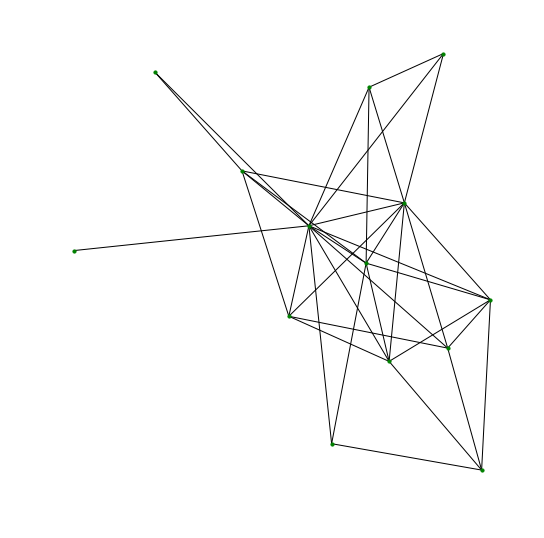

In [78]:
celtics_graph = create_team_graph('Boston Celtics', pp_G, 'green')

Create "optimized" graph where we keep the connections between players only from the same teams

In [79]:
def create_opt_team_graph(teams, original_graph, show = True):
    full_graph = nx.Graph()
    for team in teams:
        team_graph = create_team_graph(team, original_graph, "red", show = False)
        full_graph = nx.compose(team_graph, full_graph)
    if show:
        plt.figure(figsize=(7, 7))
        nx.draw(full_graph, node_size = 10)
        plt.show()
    return full_graph

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

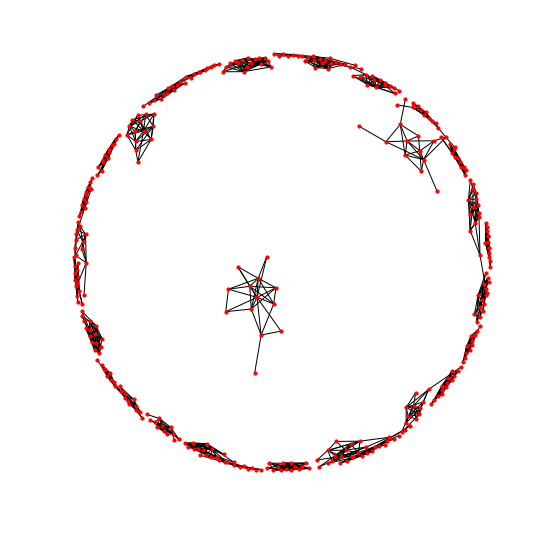

30


In [80]:
teams_name = teams['Team'].tolist()
opt_team_graph = create_opt_team_graph(teams_name, pp_G)
print(nx.number_connected_components(opt_team_graph))

In [81]:
edges_deletion(opt_team_graph.number_of_edges(), 'team')

This  team  graph has  1119 edges
We have then deleted  6566 edges ( 85.44 %)


### From optimal graph to real graph

In [82]:
def accuracy_clustering(graph, k, nb_iter):
    c, l = apply_kmeans(nx.to_numpy_matrix(graph), k, nb_iter)
    clusters, nb_lists = compute_names_per_cluster(l, k, graph)
    accuracy = compute_accuracy(clusters, nb_lists, graph)
    return accuracy

In [83]:
from random import shuffle

def adding_edges(opt_graph, real_graph, level_name, edges_per_step = 50, edges_to_draw = [50, 500, 1000]):
    
    # Get all edges that are in the real graph but not in the optimal graph
    opt_copy = opt_graph.copy()
    opt_edges = opt_graph.edges()
    full_edges = real_graph.edges()
    edges_to_add = list(set(full_edges).difference(set(opt_edges)))
    shuffle(edges_to_add)
    nbr_edges = []
    accuracies = []
    
    # Depending on the level_name, change number of wanted clusters
    k = 0
    if level_name == 'Conference':
        k = 2
    elif level_name == 'Division':
        k = 6
    elif level_name == 'Team':
        k = 30
    else:
        raise ValueError('Wrong level name, should be: Conference (k = 2), Division (k = 6) or Team (k = 30)')
    
    # Compute accuracy of optimal graph
    accuracy, _ = accuracy_clustering(opt_copy, k, 1000)
    print("Accuracy of optimal graph: {}%".format(accuracy))
    accuracies.append(accuracy)
    nbr_edges.append(0)
    
    # Compute accuracy of optimal graph with added edges
    nbr_steps = int(len(edges_to_add) / edges_per_step)
    for i in range(nbr_steps):
        low_bound = edges_per_step * i
        high_bound = edges_per_step * (i + 1)
        # If we go above the length of the  (happening during last loop)
        if high_bound > len(edges_to_add):
            high_bound = len(edges_to_add)
        
        # Add some edges to the optimal graph
        edges = edges_to_add[low_bound:high_bound]
        opt_copy.add_edges_from(edges)
        
        # Compute accuracy of clustering
        accuracy, _ = accuracy_clustering(opt_copy, k, 1000)
        #print("Accuracy of optimal graph with {} added edges: {}%".format(high_bound, accuracy))
        if accuracy == 'ERROR : Unclear attribution':
            # Append last element of list
            accuracies.append(accuracies[-1])
        else:
            accuracies.append(accuracy)
        nbr_edges.append(high_bound)
        
        if high_bound in edges_to_draw:
            print("Graph by adding {} edges selected randomly".format(high_bound))
            plt.figure(figsize=(7, 7))
            nx.draw(opt_copy,node_size = 10)
            plt.show()
    
    accuracy, _ = accuracy_clustering(real_graph, k, 1000)
    print("Accuracy of real graph: {}%".format(accuracy))
    accuracies.append(accuracy)
    nbr_edges.append(len(full_edges))
    return nbr_edges, accuracies

In [88]:
def plot_accuracy(list_added_edges, list_accuracies, level):
    # Add a polyfit curve
    coeff = np.polyfit(list_added_edges, list_accuracies, 3)
    f = np.poly1d(coeff)
    p2 = [f(x) for x in list_added_edges]
    # Orange curve shows actual accuracy at each step
    plt.plot(list_added_edges, list_accuracies, color = 'orange')
    # Green curve shows the polyfit curve based on all the accuracies
    plt.plot(list_added_edges, p2, color = 'green')
    plt.ylim([0,100])
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Number of added edges')
    plt.title('Accuracy in function of number of added edges for the {} graph'.format(level))
    plt.show()

#### Conference Level

Accuracy of optimal graph: 90.58%
Graph by adding 50 edges selected randomly


C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

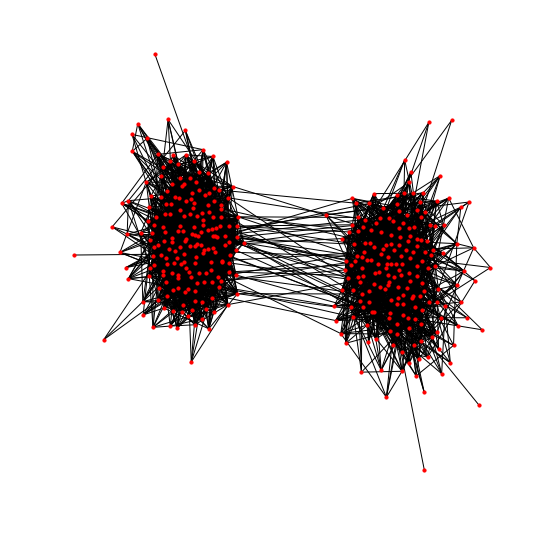

Graph by adding 500 edges selected randomly


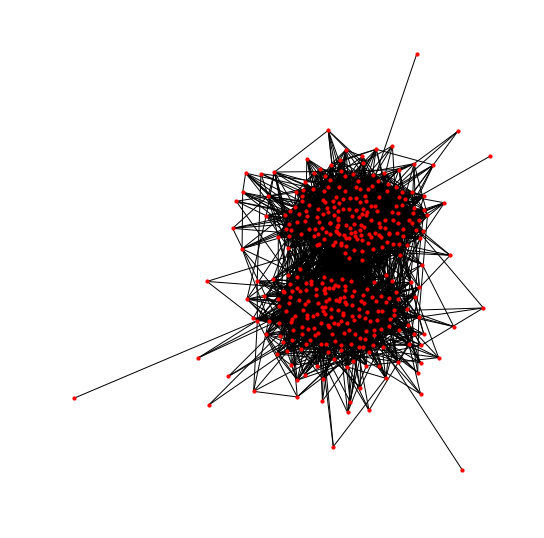

Graph by adding 1000 edges selected randomly


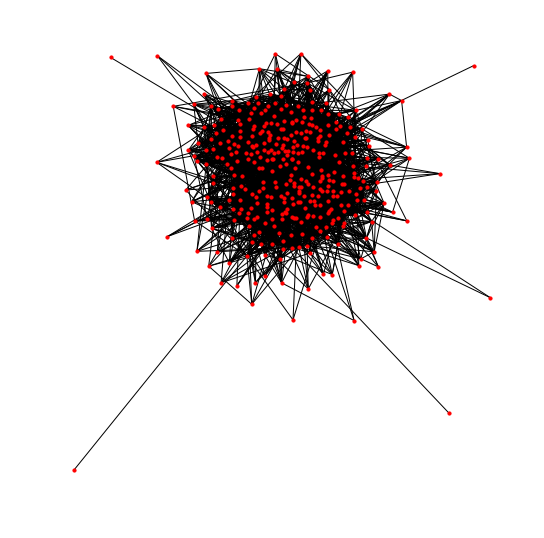

Accuracy of real graph: 53.14%


In [85]:
nbr_edges_conf, accs_conf = adding_edges(conf_graph, pp_G, 'Conference')

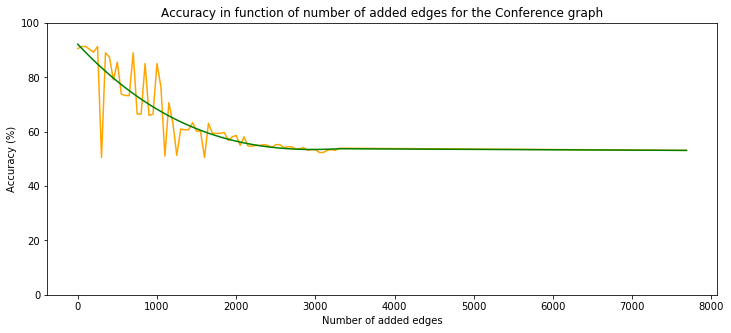

In [86]:
plot_accuracy(nbr_edges_conf, accs_conf, "Conference")

For the conference level, going from the optimal graph to the real graph resulted in the addition of 3308 edges. From the plots we see that the clustering is stil observable by adding 50 edges (around 90% clustering accuracy from the graph) or 500 edges (80% accuracy) and is less observable when adding 1000 edges (60% accuracy). However, as we saw in the previous parts, the accuracy decreases the more we add edges in order to have the real graph (53% accuracy)

#### Division Level

Accuracy of optimal graph: 45.81%
Graph by adding 50 edges selected randomly


C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

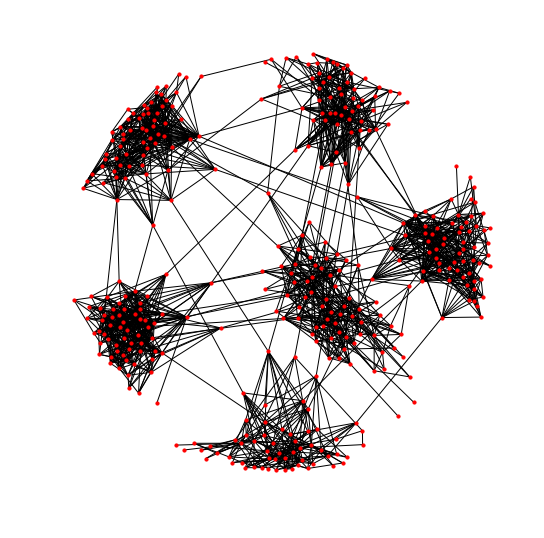

Graph by adding 500 edges selected randomly


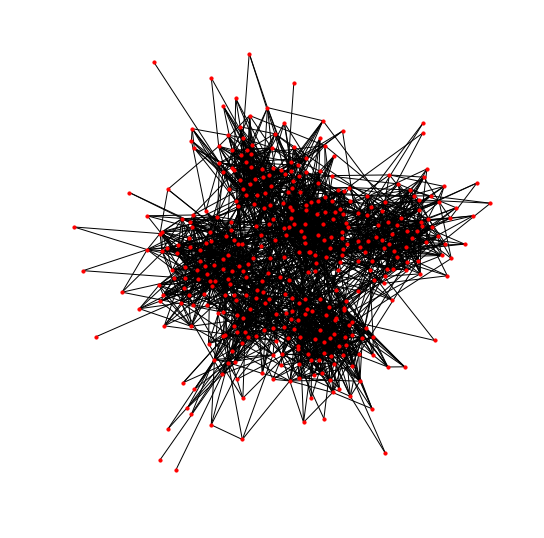

Graph by adding 1000 edges selected randomly


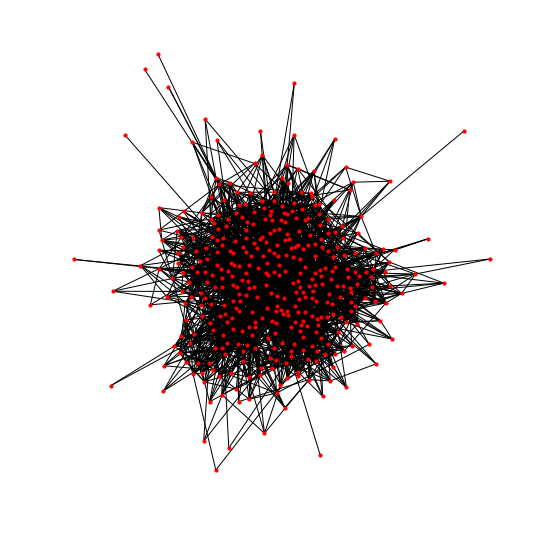

Accuracy of real graph: 24.08%


In [87]:
nbr_edges_div, accs_div = adding_edges(opt_div_graph, pp_G, 'Division')

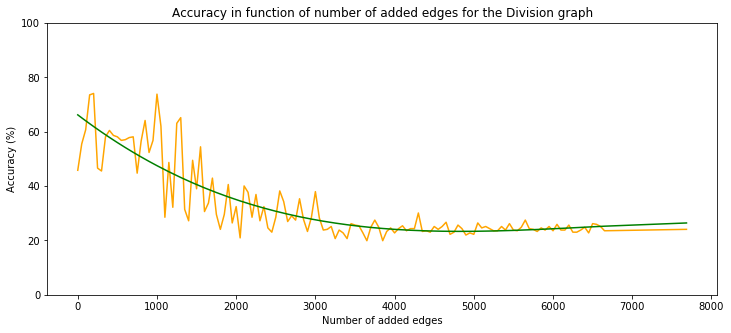

In [89]:
plot_accuracy(nbr_edges_div, accs_div, "Division")

For the division level, going from the optimal graph to the real graph resulted in the addition of 5639 edges. From the plots we see that the clustering is stil observable by adding 50 edges (around 65% clustering accuracy from the graph) but not that much with 500 edges (55% accuracy) or even 1000 edges (50% accuracy). However, as we saw in the previous parts, the accuracy decreases the more we add edges in order to have the real graph (25% accuracy)

#### Team Level

Accuracy of optimal graph: 54.71%
Graph by adding 50 edges selected randomly


C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

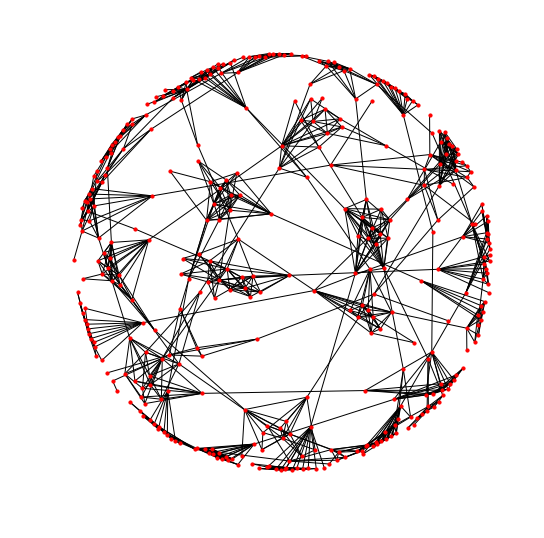

Graph by adding 500 edges selected randomly


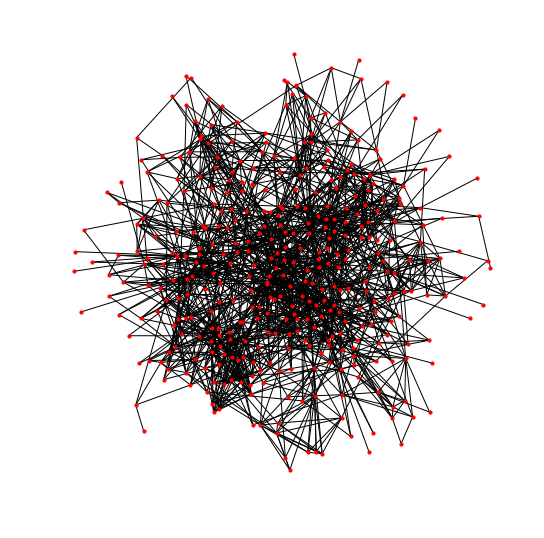

Graph by adding 1000 edges selected randomly


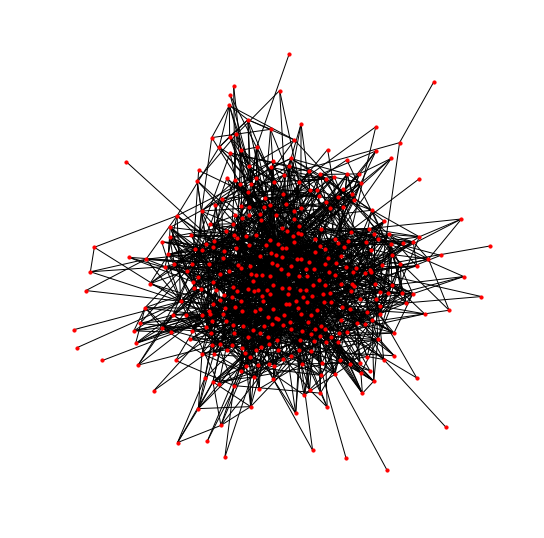

Accuracy of real graph: 16.49%


In [90]:
nbr_edges_team, accs_team = adding_edges(opt_team_graph, pp_G, 'Team')

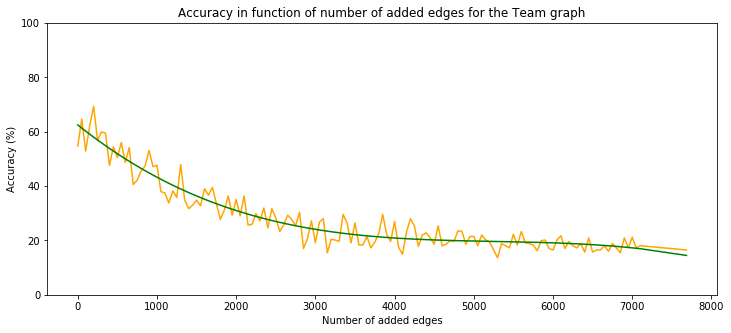

In [91]:
plot_accuracy(nbr_edges_team, accs_team, "Team")

For the team level, going from the optimal graph to the real graph resulted in the addition of 6566 edges. From the plots we see that the clustering is stil observable by adding 50 edges (around 62% clustering accuracy from the graph) but not that much with 500 edges (50% accuracy) and not at all with 1000 edges (40% accuracy). As we saw in the previous parts, the accuracy decreases the more we add edges in order to have the real graph (16% accuracy with K-means used for the graph and 27% with GMM as seen previously)

[Back to top](#index)

<a id='ptgraph'></a>

# 4. Player-Team Graph

Study of the graph consisting of one node for each player and one node for each team. The edges will be according to whether a player follows a team twitter or not. <br>
This diverge a little bit from the clustering between players only. However this remains in the domain of twitter connections. This is still relevant as a player could choose to follow every team or only his and the players follow the teams independently from each other.

<a id='ptconstruct'></a>

## 4.A Construction

In [92]:
#Create empty graph for player following teams graph
pt_G = nx.Graph()

In [93]:
#Add all the teams as node, mention it in category attribute
team_names = teams['Team'].unique()
for i, t in enumerate(teams['Twitter'].unique()):
    pt_G.add_node(t, name= team_names[i] , cat = 'team')

In [94]:
pt_G.node['@celtics']['cat']

'team'

In [95]:
#Add all the players as node, mention it in category attribute
player_names = players_2017.index
for i, p in enumerate(players_2017['Twitter_name']):
    pt_G.add_node(p, name= player_names[i] , cat = 'player')

In [96]:
pt_G.node['@KingJames']['cat']

'player'

In [ ]:
#Add edges to the graph
#For every team, we will check which player follows
errors = []
for i, t in enumerate(teams['Twitter'].unique()):
    #Print team to check progress
    print('TEAM : ', t[1:])
    for p in players_2017['Twitter_name']:
        try:
            #Compute the friendship between team and target
            #we get rid of the '@' for both screen_name
            friendship = api.show_friendship(source_screen_name= t[1:], 
                                             target_screen_name= p[1:])
            #If the team is followed by the player, then we add an edge
            if friendship[0].followed_by:
                pt_G.add_edge(t, p)
        except: 
            errors.append(p)
    nx.write_gpickle(pt_G, 'subgraphs/'+str(i)+t)

TEAM :  celtics
Rate limit reached. Sleeping for: 807


From the created graph, we observed that 5 teams had no followers and that around 100 players were not following any team's twitter. We decided to remove these 5 teams (only 25 remaining) and these players (301 remaining) in order to avoid having isolated nodes in the graph.

In [52]:
unconnected_teams = set(nx.isolates(pt_G)).intersection(set(teams['Twitter'].unique()))
unconnected_players = set(nx.isolates(pt_G)).intersection(set(players_2017['Twitter_name']))
pt_G.remove_nodes_from(nx.isolates(pt_G))

We apply a color mapping regarding the category to display nicely the graph (red nodes as teams and blue nodes as players): 

In [53]:
colors = []
for n in pt_G.nodes():
    if pt_G.node[n]['cat'] == 'team':
        colors.append('red')
    else:
        colors.append('blue')

/Users/emma/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/emma/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/emma/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/emma/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

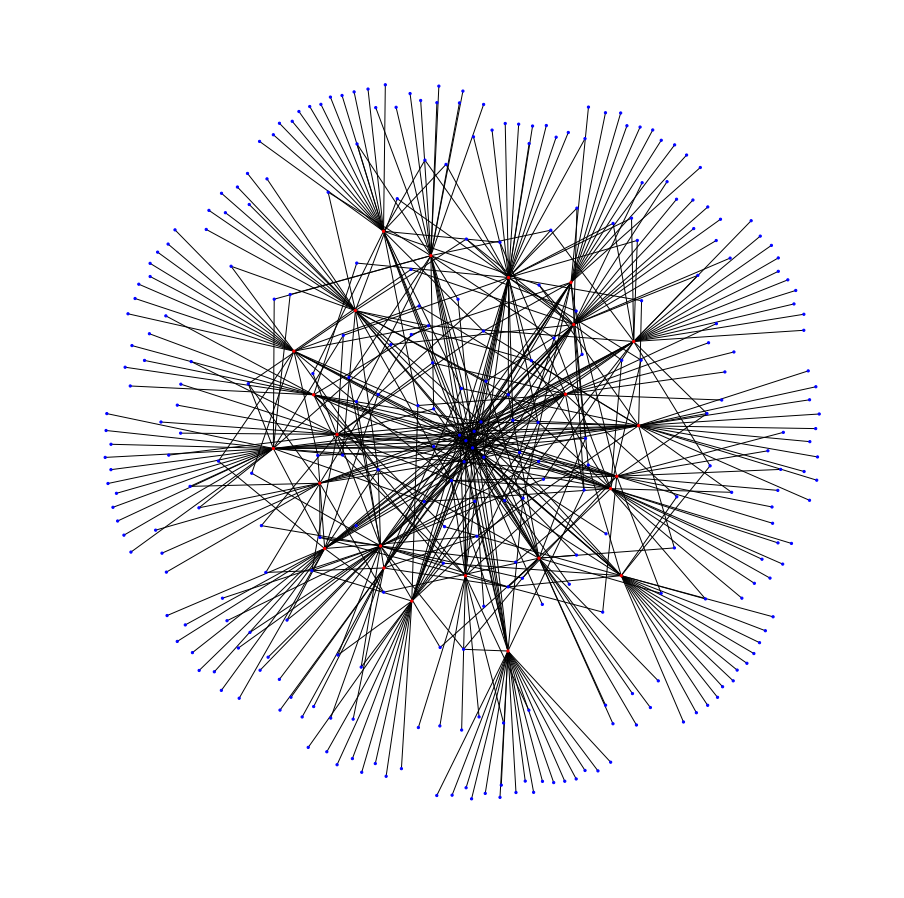

In [54]:
plt.figure(figsize=(12, 12))
nx.draw_spring(pt_G, node_size = 5, node_color=colors)
plt.show()

We can directly see that the clusters are more visible, although they might not be very representative of the ground truth: e.g. a player might only follow the twitter of an old team he played with instead of following the twitter of his 2017 team. <br>

In [55]:
#Write graph to disk
#nx.write_gpickle(pt_G, 'pt-graph')

In [36]:
#Load graph from disk
pt_G = nx.read_gpickle('pt-graph')

[Back to top](#index)

<a id='ptanalysis'></a>

## 4.B Analysis

In [9]:
teams_nodes = []
teams_nodes_indexes = []
team_degrees = []
for i, n in enumerate(pt_G.nodes()):
    if pt_G.node[n]['cat'] == 'team':
        teams_nodes.append(n)
        teams_nodes_indexes.append(i)
        team_degrees.append(pt_G.degree(n))

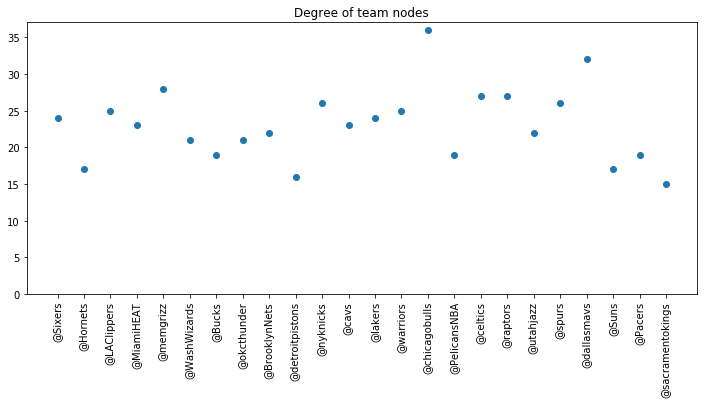

In [10]:
fig, ax = plt.subplots(1,1) 
fig.set_size_inches((12, 5))
ax.scatter(range(len(teams_nodes)),team_degrees)
plt.title('Degree of team nodes')
ax.set_xticks(range(len(teams_nodes)))
ax.set_xticklabels(teams_nodes, rotation='vertical')
ax.set_ylim(0)
plt.show()

We can see that all the teams have at least 15 followers among the players, this is a good news as there are around 10 to 15 players in one team.

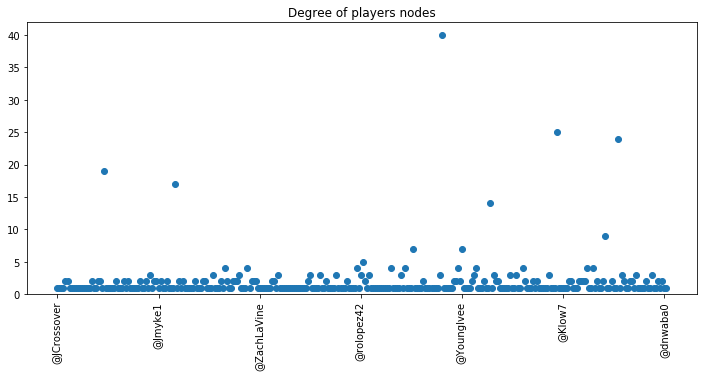

In [12]:
players = []
players_degrees = []
for n in pt_G.nodes():
    if pt_G.node[n]['cat'] == 'player':
        players.append(n)
        players_degrees.append(pt_G.degree(n))
        
fig, ax = plt.subplots(1,1) 
fig.set_size_inches((12, 5))
ax.scatter(range(len(players)), players_degrees)
plt.title('Degree of players nodes')
ax.set_xticklabels(players, rotation='vertical')
ax.set_ylim(0)
plt.show()

We can see that the players seems to follow less than 5 teams in the vast majority with most of them following only 1 team (that may be their actual team). This is also good news for our clustering !
<br>

[Back to top](#index)

<a id='ptteam'></a>

## 4.C Cluster at team level

We still have 2 conferences and 6 divisions, except we deleted some teams and some players. We need to make thoses changes also in a copy of players_2017 otherwise the accuracy functions will not be of any use. <br>

However as the players are linked to a team we will limit ourselves to the study of team clustering.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\olivi\Anaconda3\lib\site-packages\scipy\cluster\vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:01<00:00,  4.22s/it]


The number of correct attribution of clusters is  0  over  100


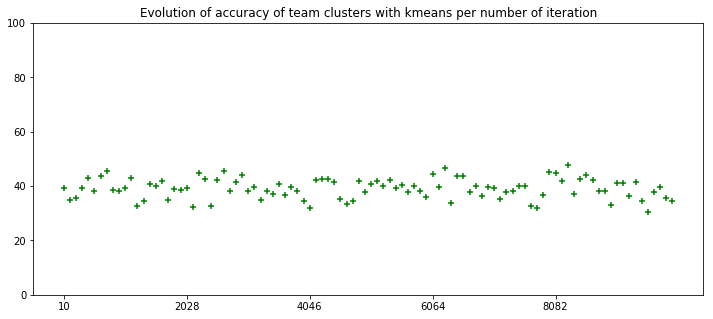

The best value was with  8284 iterations giving accuracy :  47.85


In [34]:
#With kmeans
compute_kmeans(pt_G, 'team', 25, nx.to_numpy_matrix(pt_G), np.linspace(10, 1e4, 100, dtype=int))

Best accuracy with K-means is 47.85% which is, as we could have imagined, better than the accuracy obtained when clustering the graph in Section 3 (accuracy of 27%). The graph of this part is only based on the connections between players and their teams whereas it was based on players connections in Section 3. Even if the clustering accuracy is way better than randomness which would be $\frac{100\%}{25\ teams} = 4\%$ (25 teams because we removed the 5 teams that had no players following them and thus removed the players from these teams), it would be hard to obtain a higher accuracy because players move a lot in different teams through the years and some of them may be following the twitter of their old team of 2015 for example instead of their new team (2017). We also observe from the graph and the plot of the players degree that some players are following multiple teams (i.e. the nodes in the center of the graph connected to multiple team nodes): these players might follow all their previous teams and did not unfollow them while changing of team through the years. This kind of players does not help getting a perfect accuracy in the clustering as the clustering algorithm will have difficulty matching these players to their actual team/cluster.

We can conclude that most players tend to follow their 2017 team's twitter.

[Back to top](#index)

<a id='rookie'></a>

# 5. Rookie Graph

This graph will be made by just using the "rookie" players of 2017 that were not playing in 2013. <br>
Indeed we made the hypothesis that rookie players are more likely to have less connections because of their "recent" appearance in the NBA and those will be more targetted to their team.

<a id='rookieconstruct'></a>

## 5.A Construction
##### Graph that only contains the "rookie" players (new players since 2013 that played in the 2017 season): 

To construct the graph, we only keep the players from the players_2017 dataframe that did not appear in the players_2013 dataframe

In [97]:
new_players = set(list(players_2017.index)).difference(set(list(players_2013.index)))
old_players = set(list(players_2017.index)).intersection(set(list(players_2013.index)))
print('Number of new players : ', len(new_players))
print('Number of old players : ', len(old_players))
new_players_df = players_2017.loc[new_players]
new_players_df.head()

Number of new players :  242
Number of old players :  140


Team     Twitter_name  \
Name                                                    
Delon Wright         Toronto Raptors     @delonwright   
Hassan Whiteside          Miami Heat  @youngwhiteside   
Joffrey Lauvergne  San Antonio Spurs         @1JOLOLO   
Kadeem Allen          Boston Celtics     @AllenKadeem   
Troy Daniels            Phoenix Suns     @troydaniels   

                                      Wiki            Division  \
Name                                                             
Delon Wright            /wiki/Delon_Wright   Atlantic Division   
Hassan Whiteside    /wiki/Hassan_Whiteside  Southeast Division   
Joffrey Lauvergne  /wiki/Joffrey_Lauvergne  Southwest Division   
Kadeem Allen            /wiki/Kadeem_Allen   Atlantic Division   
Troy Daniels            /wiki/Troy_Daniels    Pacific Division   

                           Conference  connections  team_connections  
Name                                                                  
Delon Wright       EASTERN CONFERENCE           14                 5  
Hassan Whiteside   EASTERN CONFERENCE           42                 6  
Joffrey Lauvergne  WESTERN CONFERENCE           18                 3  
Kadeem Allen       EASTERN CONFERENCE            6                 1  
Troy Daniels       WESTERN CONFERENCE           70                 4

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

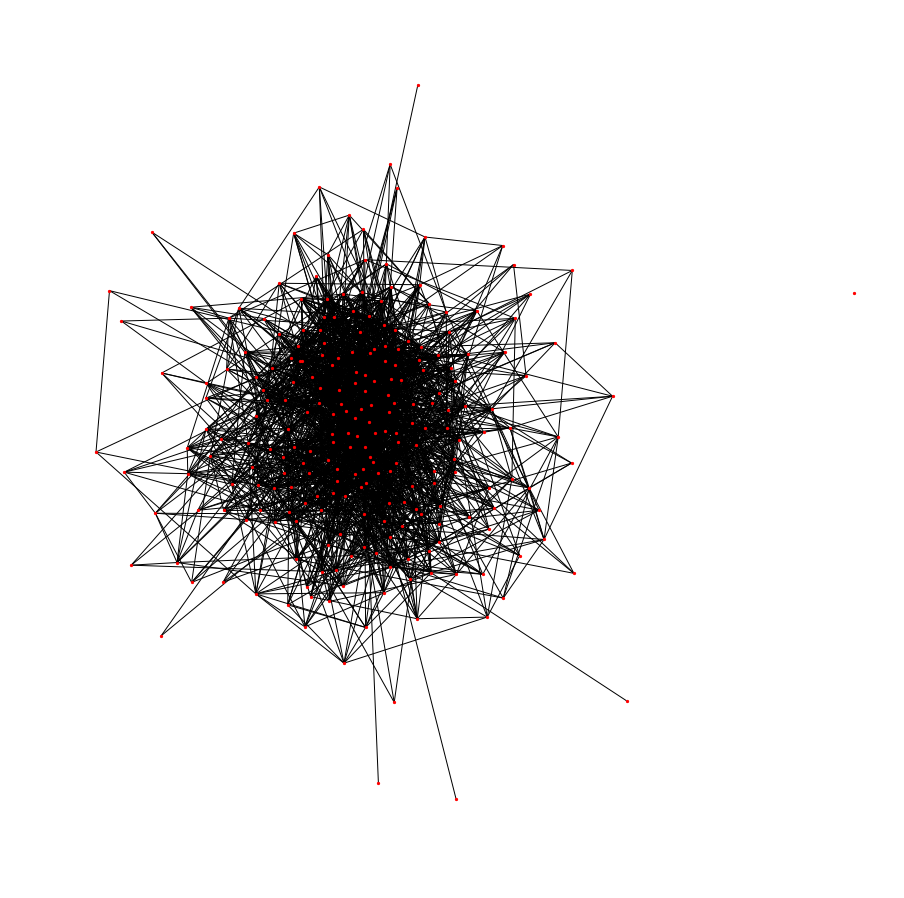

In [98]:
rookie_G = pp_G.copy()

rookie_G.remove_nodes_from(players_2017.loc[old_players]['Twitter_name'].tolist())
plt.figure(figsize=(12, 12))
nx.draw_spring(rookie_G, node_size = 5)
plt.show()

In [99]:
# New dataframe containing only the rookie players
rookie_players_2017 = players_2017.loc[new_players]

[Back to top](#index)

<a id='rookieanalysis'></a>

## 5.B Analysis

In [100]:
analyse_isolation_graph(rookie_G)

Number of isolated nodes :  1  ( 0.41 %)
Giant Component represents  241  nodes ( 1.0 %)
There are  2  components ( 1  without isolated nodes)
The average clustering coefficient is :  0.25034249636144995


In [101]:
clean_isolated_nodes(rookie_G, rookie_players_2017)

There are 1 players with no connections from 242 total players
There are 8 players with no team connections from 241 total players


In [102]:
#As we made changes to players_2017, we need to update the ground truth lists
east_players, west_players, division_players, team_players = update_ground_truth(rookie_players_2017)

The diameter of this graph is :  5


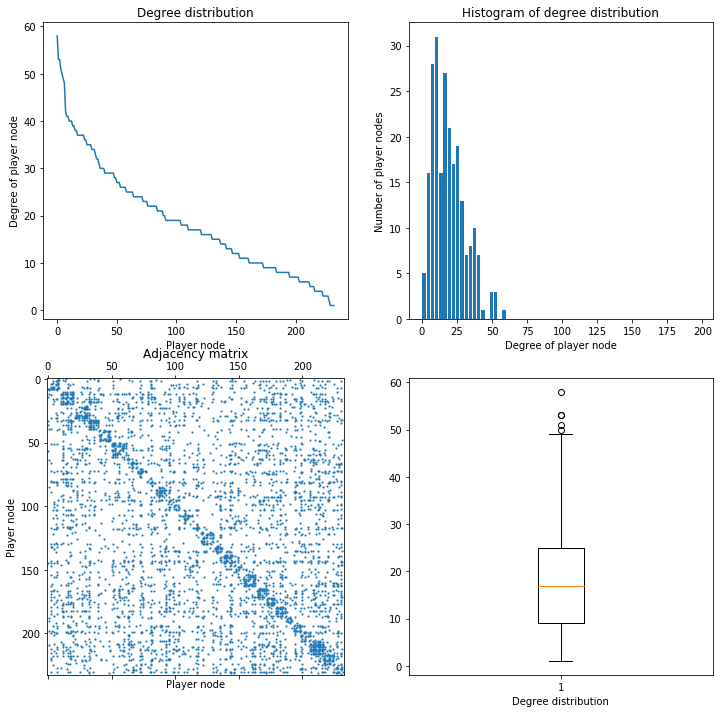

The largest clique of this graph is composed of the players :  ['Kentavious Caldwell-Pope', 'Vander Blue', 'Jordan Clarkson', 'Larry Nance Jr.', 'Lonzo Ball', 'Kyle Kuzma', 'Brandon Ingram', 'Ivica Zubac']


In [103]:
analyse_degree_distribution(rookie_G)

In [106]:
update_team_connectivity(teams, rookie_players_2017)

The average of player connections to players from the same team is 19.15791178847167 %


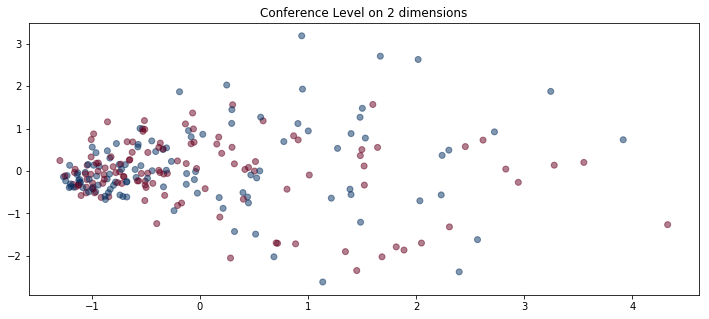

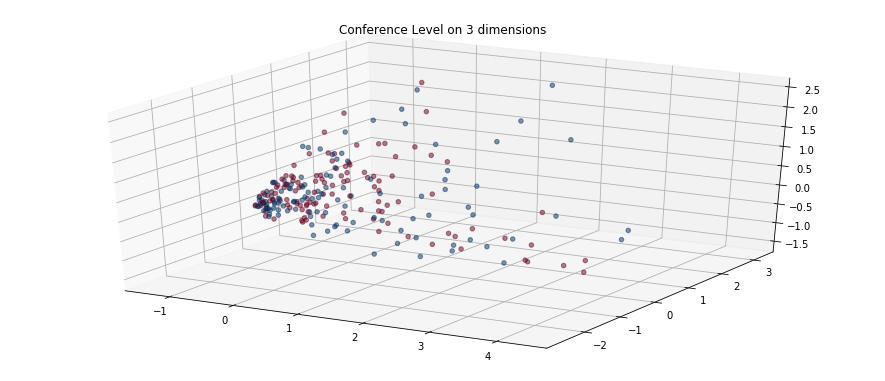

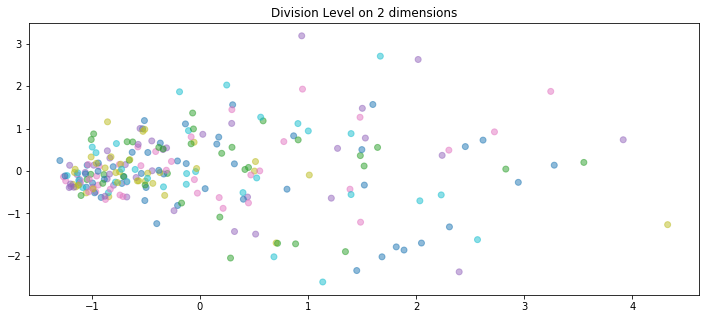

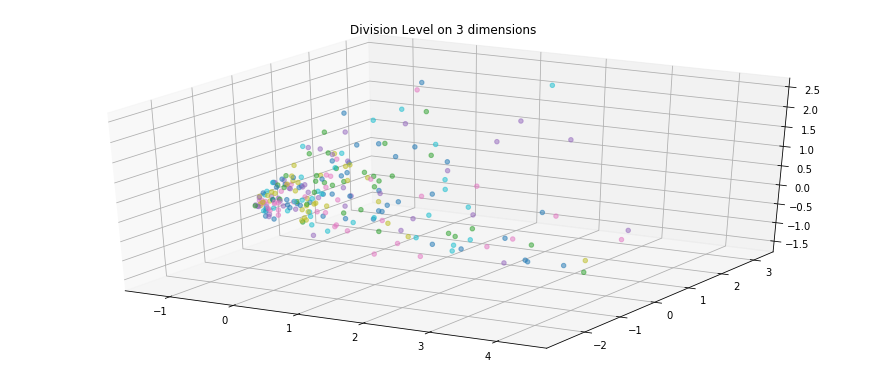

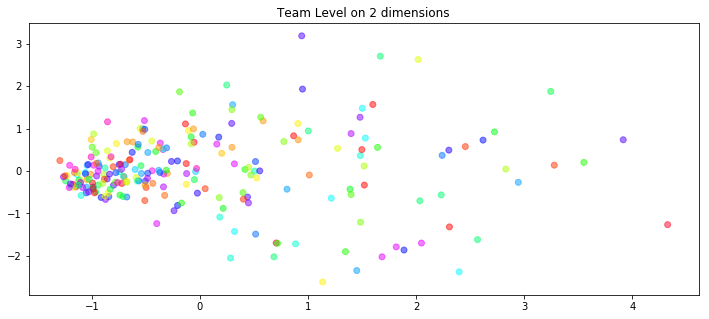

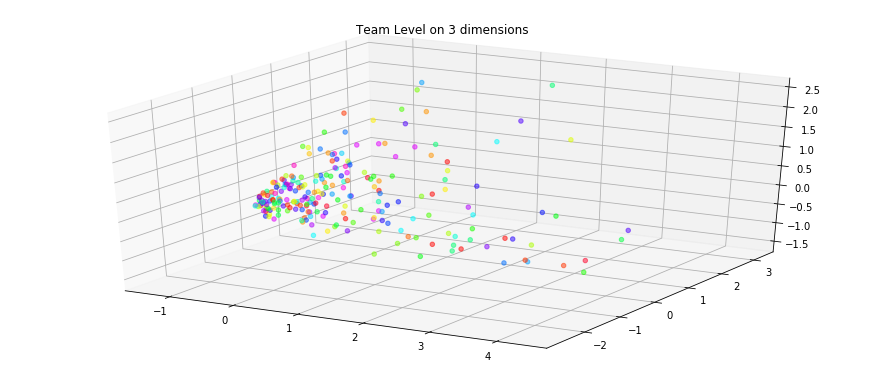

In [80]:
visualize_pca(rookie_G, rookie_players_2017)

[Back to top](#index)

<a id='rookieteam'></a>

## 5.C Cluster at team level

100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


The number of correct attribution of clusters is  0  over  20


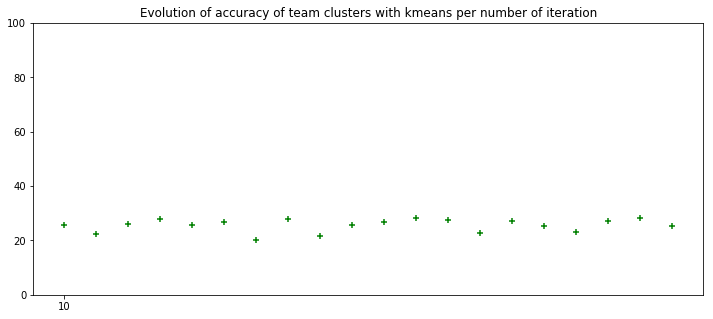

The best value was with  5793 iterations giving accuracy :  28.33


In [174]:
#With K-means
compute_kmeans(rookie_G, 'team', 30, nx.to_numpy_matrix(rookie_G), np.linspace(10, 1e4, 20, dtype=int))

100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


The number of correct attribution of clusters is  0  over  20


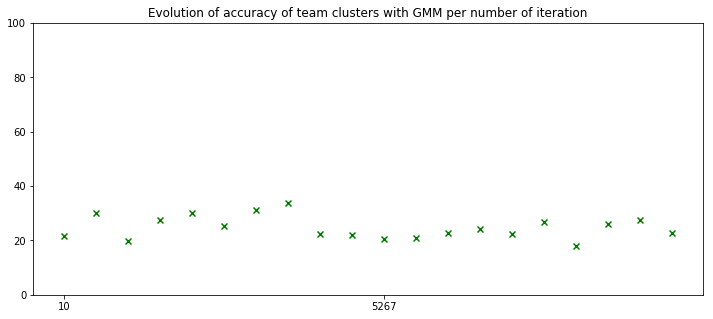

The best value was with  3690 iterations giving accuracy :  33.91


In [178]:
#With GMM
compute_GMM(rookie_G, 'team', 30, nx.to_numpy_matrix(rookie_G), np.linspace(10, 1e4, 20, dtype=int))

__Best Results__ : <br>
With GMM, 3690 iterations : 33.91 accuracy

The best accuracy has been obtained with the GMM, yielding an accuracy of 33.91%. When we compare to the accuracy of the original Player-Player graph (section 3) we conclude that using only the "rookies" augment our accuracy by 6 percentage points (accuracy of 27.31% in Player-Player Graph), which is a nice enhancement. Hence it appears that our assumption was true: the players already present in 2013 have connections such that it acts like a noise for the team clustering. We take as examples 2 facts: old players have often been in multiple teams and are connected to them and their old teammates ; all-stars are often old players, and are connected to a lot of players and teams just because of their reputations. This filter also shows us that the degrees of players are decreasing in comparison to the other implemented methods (seen in the histogram of degree distributions).

[Back to top](#index)

<a id='double'></a>

# 6. Double connection graph

This graph is made from the list of edges gathered for the original Player-Player graph of Section 3. <br>
In order to sparsify the adjacency matrix, we will keep only the connections between players when the 'friendship' is mutual. That is to say that we have in the list both an edge (player A, player B) and an edge (player B, player A).

<a id='doubleconstruct'></a>

## 6.A Construction

##### Graph with only links between players that are following each other (p1 -> p2 AND p2 -> p1):

In [107]:
double_players_2017 = pd.DataFrame.from_csv('players_twitter_2017.csv')
double_players_2017.drop_duplicates(subset='Twitter_name', inplace=True)

We collect all the edges from the files and create a dictionary to store the edges as follows and check if the connection is reciprocal: (p1, p2) as keys for all edges between players, 1 (single connection) or 2 (double connection) as values.

In [108]:
edge_files = ['@GTemp14', '@khawileonard', '@Khris22m', '@Timfraz23', '@Oli_newTweets', '@Emma_newTweets', '@Matt_newTweets']
edges_dict = {}

for edge_file in edge_files:
    with open(edge_file, 'rb') as f : 
        edge_list = pickle.load(f)
        for edge in edge_list:
            opposite_edge = (edge[1], edge[0])
            if opposite_edge in edges_dict.keys():
                # If opposite_edge already exists in the dictionary:
                edges_dict[opposite_edge] += 1
            else:
                # Otherwise append edge in the dictionary
                edges_dict[edge] = 1

From edges_dict we only keep the edges with 2 as the corresponding value, meaning there is a mutual connection between the 2 players: 

In [109]:
double_edges = []
for edge in edges_dict.keys():
    if edges_dict[edge] == 2:
        # If there is the dual connection p1 -> p2 AND p2 -> p1
        double_edges.append(edge)
print('Number of double edges : ',len(double_edges), ' compared to ', len(edges_dict),' before')

Number of double edges :  4352  compared to  7993  before


In [110]:
# Create the new graph
double_G = nx.Graph()
player_names = double_players_2017.index
for i, p in enumerate(double_players_2017['Twitter_name'].unique()):
    double_G.add_node(p, name= player_names[i])
double_G.add_edges_from(double_edges)

C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\olivi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

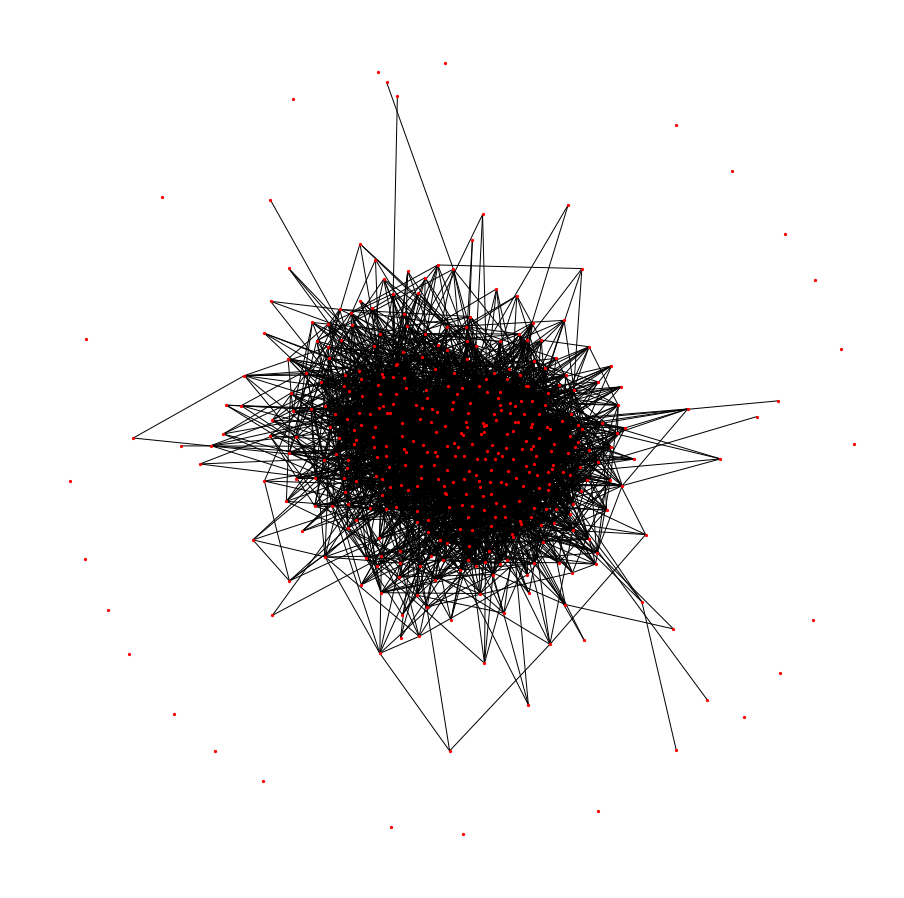

In [111]:
#Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_spring(double_G, node_size = 5)
plt.show()

[Back to top](#index)

<a id='doubleanalysis'></a>

## 6.B Analysis

In [112]:
analyse_isolation_graph(double_G)

Number of isolated nodes :  24  ( 5.81 %)
Giant Component represents  389  nodes ( 0.94 %)
There are  25  components ( 1  without isolated nodes)
The average clustering coefficient is :  0.24769010272565806


In [113]:
clean_isolated_nodes(double_G, double_players_2017)

There are 24 players with no connections from 413 total players
There are 51 players with no team connections from 389 total players


In [114]:
#As we made changes to players_2017, we need to update the ground truth lists
east_players, west_players, division_players, team_players = update_ground_truth(double_players_2017)

The diameter of this graph is :  5


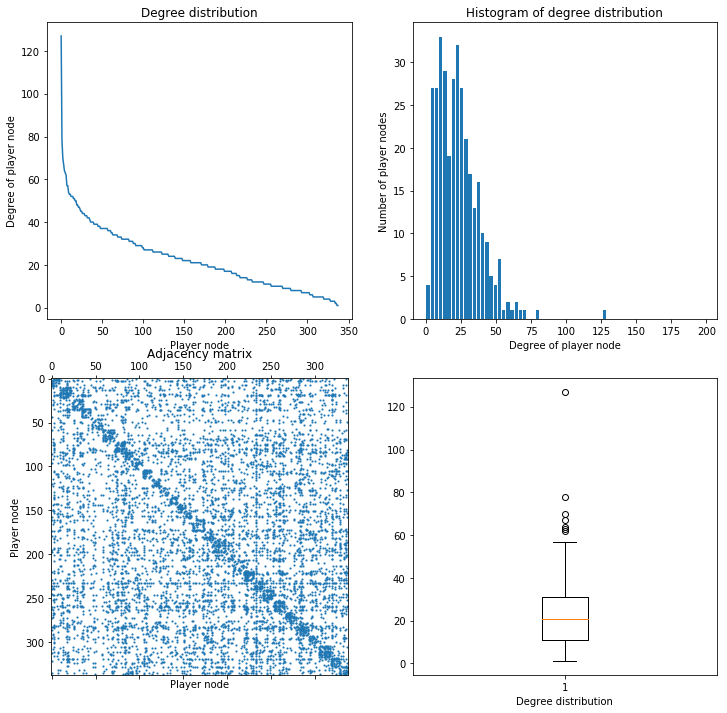

The largest clique of this graph is composed of the players :  ['Carmelo Anthony', 'J. R. Smith', 'Chris Paul', 'Paul George', 'Blake Griffin', 'Kevin Durant', 'Russell Westbrook', 'LeBron James', 'Kevin Love', 'James Harden']


In [115]:
analyse_degree_distribution(double_G)

In [107]:
update_team_connectivity(teams, double_players_2017)

The average of player connections to players from the same team is 16.824541826542603 %


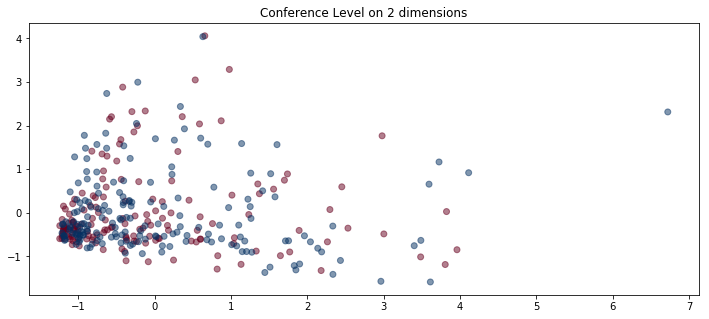

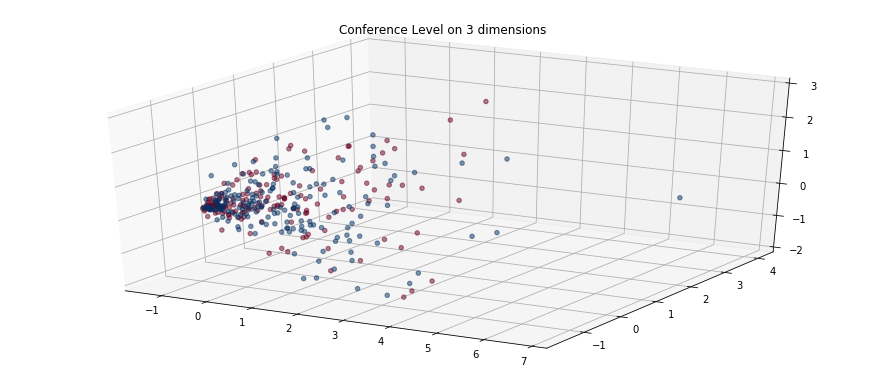

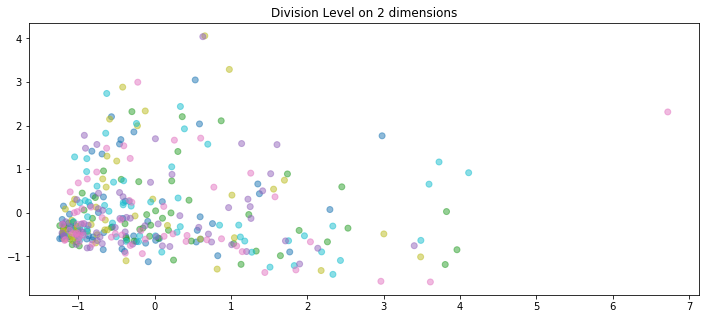

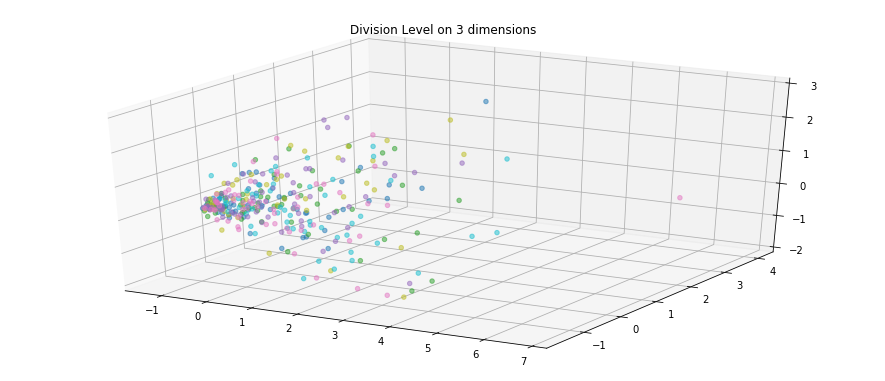

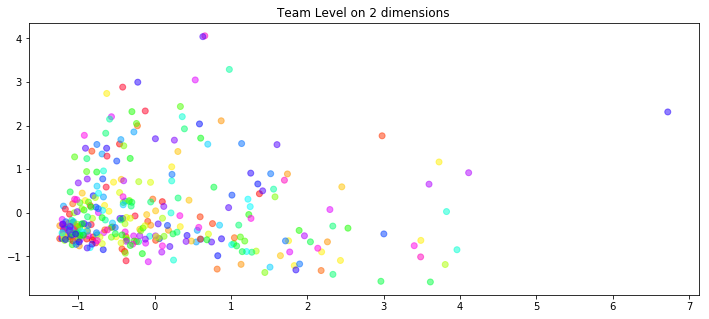

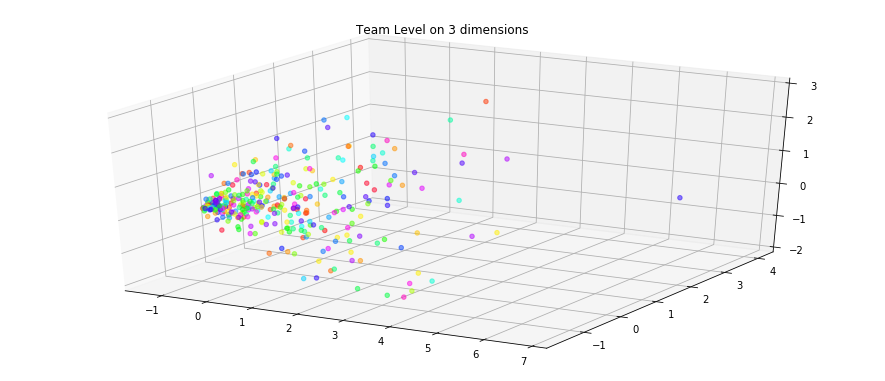

In [111]:
visualize_pca(double_G, double_players_2017)

[Back to top](#index)

<a id = 'doubleteam'></a>

## 6.C Cluster at team level

100%|██████████| 20/20 [01:03<00:00,  3.17s/it]


The number of correct attribution of clusters is  0  over  20


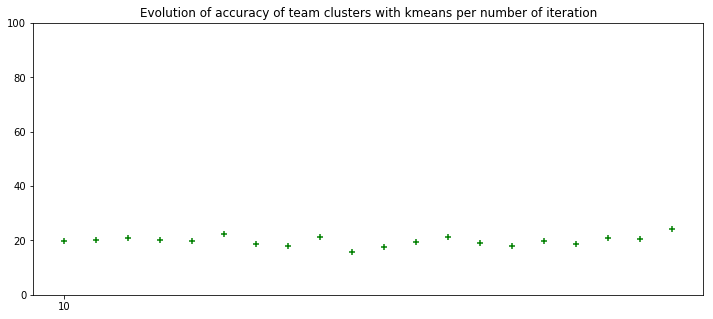

The best value was with  10000 iterations giving accuracy :  24.26


In [176]:
#With K-means
compute_kmeans(double_G, 'team', 30, nx.to_numpy_matrix(double_G), np.linspace(10, 1e4, 20, dtype=int))

100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


The number of correct attribution of clusters is  0  over  20


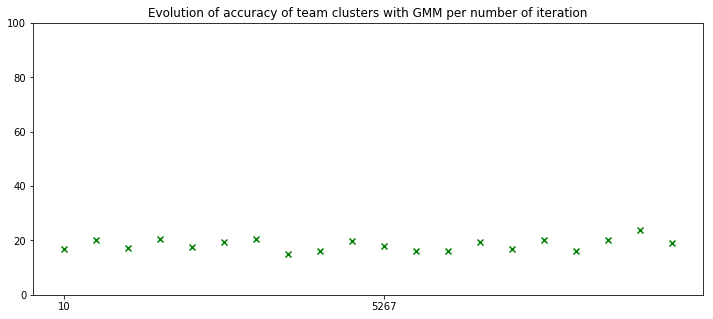

The best value was with  9474 iterations giving accuracy :  23.67


In [180]:
#With GMM
compute_GMM(double_G, 'team', 30, nx.to_numpy_matrix(double_G), np.linspace(10, 1e4, 20, dtype=int))

We obtain our best result with kmeans and 10000 iterations, giving an accuracy of 24.26%. This accuracy is not superior to the real Player-Player graph (27.23% with GMM). We have previously seen that the all-stars are a problem to our clustering, but this filter tends to dimnish their impact by ensuring that the connections are mutual. Hence, as many players follow the all-stars without being followed by them, we get rid of a lot of parasite edges that were making the all-stars players a major issue. But still, we have to note that the all-stars still have played in many different teams and so they still keep a lot of connections with their old teammates, and these connections are maybe amplified by the absence of the "parasite" edges that we just talked about. This may be the reason why we obtain a smaller accuracy than the real graph, and even smaller than the one for the rookie graph.

[Back to top](#index)

<a id='ccl'></a>

# 7. Conclusion

During this project we have used our Twitter data to try to cluster the teams, divisions and conferences of the NBA. If the results are far from perfect, we have used different techniques to highlight some characteristics of the graph composed by the NBA players and their connections between them (mutual or not). <br>

The first thing we did was to build the Player-Player graph (Section 3) and try to cluster the conferences, divisions and teams directly with the raw data. By doing this we obtained our first accuracy measures which quality was variable when compared to the random clustering accuracy: conferences clustering has 53.93% accuracy against 50% accuracy for random assignment of the players to one of the clusters; divisions and teams were clustered a bit better with respectively 27.5% against 16.6% (random assignment) and 27.23% against 3% (random assignment). These results were far from being perfect so, after analysing the network, we made 2 important observations:<br>

-The ratio of team connections for a player is in average of 14.39% in the real graph, which is low when you want to cluster the different teams. <br>
-The adjacency matrix of the real graph is very dense even if we can distinguish some team clusters, which is not a sought characteristic when wanting to cluster graphs.<br>
    
We have then taken the best case of our network: the optimal graph (Section 3). This graph was composed of the edges between the players of the same conference/division/team. The number of deleted edges was quiet important, even going to 85.44% of deletion for the optimal player-player graph. This optimal graph obtained good accuracies (relatively to the number of clusters), namely 90% for conferences, 70% for divisions and 60% for teams. We then decided to add more and more edges, until we got the real graph back. We observed that the optimal graph was fine for clustering until a certain breakpoint where too many edges were added and accuracy droped down:~1000 edges for conf., ~>500 edges for div. and between 100 and 500 edges for teams. <br>

After that, we tried to cluster by using the connections between players and teams, hence creating the player-team graph (Section 4). Before analysing it, it's useful to note that we deleted the teams not followed by players and the players not following any team. The obtained graph was visually very good, clearly showing clusters of players around teams, and the degree distribution for either the team or the players seemed quite good. At the end of our clustering, we obtained an accuracy of 47.85% for the teams. This graph showed that by aknowledging the connections only between players and teams, we could almost get a clustering as good as if we were considering only the "perfect" connections between players.<br>

One of the issues for the previous graph was that some players were following multiple teams. This kind of behavior can be explained by the fact that NBA players move a lot between teams each year, and so a player moving from team A to team B would be following both teams A and B in the end. We thought about the fact that players present in the NBA since a certain amount of years were more likely to be following many teams, unlike newcomers. That's how we ended up using data from 2013 to identify the players already playing in the NBA in 2013. We got rid of the "old" players and obtained, with the reamining players, the "rookie" graph (composed of the rookie players).<br>
The clustering accuracy ended up at 33.91%, showing a nice improvement for the real graph's accuracy. This result can be traced back to the team connections per player ratio which is in the rookie graph of 19% against 14% for the real graph: rookie players follow more of their teammates compared to the old players, which seems logical when thinking back to te hypothesis that old players have played for many different teams and still follow them and their old team mates.<br>

After this, we decided to sparsify the real graph's adjacency matrix by ensuring that edges represent now mutual following between players. We ended up with keeping 54% of the edges, obtaining the double connection graph. This graph seemed promising at first, with a team connections per player ratio of 16% (better than the Player-Player graph of Section 3) and a fine looking adjacency matrix. However we obtained a 24.26% accuracy on the team clustering, inferior to the 27.23% of the Player-Player graph. How is this possible ? We think that even by taking the double connections, the issue that we described before regarding the old players is still weighting a lot in the balance. In fact, as current and old teammates have more chances to follow each other mutually, the old players are even more parasiting the clustering since their connections with old teammates are now more important in this graph than they were in the real graph.<br>

To conclude, we can safely say that taking the raw graph of the player's connection is not a good idea to compute clusters with a reliable accuracy. As Tweepy is very slow to get various Twitter informations, we got caught by time and hence were not able to present to you more advanced methods to ensure a good accuracy, but we still thought about some things that we could do to push further:<br>
-the simplest one is to try clustering a graph with rookie players and double connections between them, hence sparsifying further the adjaency matrix. <br>
-another method would be to considerate only connections dating from a certain amount of time. For example we could take only connections created since 1 year. This could ensure that players are not connected anymore to old teammates and old teams. We could also decide to keep "old made" connections but weight their edges less than recent connections.<br>
-speaking of weighting the edges, we could also use the address of the players, if available on the web, and the distance between the players to weight the edges between them. This would work well except when multiple teams come from the same city (like for Los Angeles currently).